The notebook saves the output of the last time it was run, so there is no need to run any of the code unless conducting a new experiment.

To run the code in this notebook:

*   To run the whole file, go to the runtime menu at the top and select 'run all.'

*   If the file is opened with Google Colaboratory, a single section can be run by first collpasing the section and then clicking the button that appears when hovering to the left of the text describing how many cells are hidden.

*   The Setup section should be run first. The Adversarial Attack Setup should be run before any of sections which appear after it. The respective simulation section should be run before the matching adversarial attack section.

*   The code takes a decent amount of time to run in its entirety, around 2 hours or so.



# Setup

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transformsf
from torchvision import transforms, utils, datasets
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import random
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import re

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Here is the recombination method which the simulations, performed below, rely on. It takes two parent models and creates a new child model. Each of the child model's layers are copied at random from the corresponding layers of its parents.

In [ ]:
def recombine(m1, m2):
    """Recombines two models. """
    # If we defined a way to recombine, use that.
    if hasattr(m1, 'recombine'):
        return m1.recombine(m2)
    # Recombines manually.
    child = copy.deepcopy(m1)
    # Recombines the parameters.
    for (name, p1), (_, p2) in zip(m1.named_parameters(), m2.named_parameters()):
        if torch.rand(1) < 0.5:
            child.state_dict()[name].copy_(p1)
        else:
            child.state_dict()[name].copy_(p2)
    # Recombines the submodules.
    for (name1), (name2) in zip(m1._modules, m2._modules):
        child._modules[name1] = recombine(m1._modules[name1], m2._modules[name2])
    return child


In [ ]:
def get_genes(model):
    """Returns the genes of a model. """
    genes = []
    for (name, p) in model.named_parameters():
        genes.append(p.data.flatten())
    for (name, m) in model._modules.items():
        genes.extend(get_genes(m))
    return genes

This class is an extension of PyTorch's linear layer class. It is mostly the same in terms of function, but it is extended somewhat in order to support recombination operations.

In [ ]:
class GeneticLinear(nn.Linear):

    def __init__(self, in_features, out_features, gene_size=64, bias=True):
        """
        Genetic generalization for linear layer.
        :param in_features: as for linear layer.
        :param out_features: as for linear layer.
        :param gene_size: size of gene in bits.  Longer vectors are split
            into pieces of this size (or similar) that are used as genes.
        :param bias:
        """
        super(GeneticLinear, self).__init__(in_features, out_features, bias)
        self.gene_size = gene_size
        self.num_input_genes = (in_features + gene_size - 1) // gene_size
        self.num_output_genes = (out_features + gene_size - 1) // gene_size
        self.input_gene_length = in_features // self.num_input_genes
        self.output_gene_length = out_features // self.num_output_genes

    def iter_gene(self):
        """
        Iterates over the gene of the layer.  Returns a pair,
        consisting of the position of the gene, and the gene itself.
        The position of the gene can be used to get/set the gene in the
        layer.
        """
        for input_idx in range(self.num_input_genes):
            for output_idx in range(self.num_output_genes):
                yield (input_idx, output_idx), self.get_gene(input_idx, output_idx)

    def get_gene(self, input_idx, output_idx):
        """
        Returns the gene at the given position.
        """
        input_start = input_idx * self.input_gene_length
        input_end = min(input_start + self.input_gene_length, self.in_features)
        output_start = output_idx * self.output_gene_length
        output_end = min(output_start + self.output_gene_length, self.out_features)
        g = self.weight[output_start:output_end, input_start:input_end]
        # Bias seems to change meaning after initialization. Fixing the value to True for now.
        b = self.bias[output_start:output_end]
        return g, b

    def set_gene(self, input_idx, output_idx, gene):
        """
        Sets the gene at the given position.
        """
        input_start = input_idx * self.input_gene_length
        input_end = min(input_start + self.input_gene_length, self.in_features)
        output_start = output_idx * self.output_gene_length
        output_end = min(output_start + self.output_gene_length, self.out_features)
        # Error here arising from PyTorch not allowing in-place operations on Tensors
        with torch.no_grad():
          self.weight[output_start:output_end, input_start:input_end] = gene[0]
          # Bias seems to change meaning after initialization. Fixing the value to True for now.
          self.bias[output_start:output_end] = gene[1]

    def gene_to_vector(self, gene):
        """
        Converts a gene to a vector.
        """
        return torch.cat([g.flatten() for g in gene])

    def recombine(self, other):
        """Returns a recombinant layer, obtained via recombination from the self
        layer and the other layer. """
        # Bias seems to change meaning after initialization. Fixing the value to True for now.
        child = GeneticLinear(self.in_features, self.out_features, self.gene_size, bias=True)
        for (i, j), gene in self.iter_gene():
            if torch.rand(1) < 0.5:
                child.set_gene(i, j, gene)
            else:
                child.set_gene(i, j, other.get_gene(i, j))
        return child

This the original implementation of a genetic net. In this class, each layer is considered its own gene. In this case this results in a model with three genes, one for the input layer, one for the second layer, and one for the output layer.

Aside from its purpose for use in the later simulation, it is functionally the same as a standard linear neural net with the same number of parameters.

In this notebook, this implementation is referred to as horizontal since each layer is treated as its own gene.

In [ ]:
# The original implementation of a Genetic Net. Referred to as horizontal genes later on.
# Each layer is treated as a single gene for recombination.
# For each layer, a child receives a copy of one of its parents weights for that layer chosen randomly.
class GeneticNet(nn.Module):
    def __init__(self, gene_size=64):
        super(GeneticNet, self).__init__()

        # Try vertical genes instead of horizontal.

        # Define the linear layers
        self.linear1 = GeneticLinear(784, 256, gene_size=gene_size)
        self.linear2 = GeneticLinear(256, 128, gene_size=gene_size)
        self.linear3 = GeneticLinear(128, 10, gene_size=gene_size)

    def forward(self, x):
        # Pass the input through the linear layers
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.log_softmax(self.linear3(x), dim=1)

        # Return the output
        return x

Here is another implementation of a genetic net. It is very similar to the one which appears above.

The difference is in how the second layer is handled. Here there are two second layers, 2a and 2b. Both are half the size of the second layer in the horizontal implementation. Each take the input from the input layer and their combined output is concatenated together to form the input for the classification layer. This results in a vertical split in the second layer which adds an additional gene compared to the previous implementation.

In this notebook, this implementation is referred to as vertical due to how the second layer is handled.

In [ ]:
# An alternative implmentation, similar to the first except the second layer is split into two blocks. Referred to as vertical genes later on.
# The output of the blocks are combined together for the input to the next layer.
# Each half is used as a gene for recombination, adding an extra gene compared to the above implementation.
class VerticalGeneticNet(nn.Module):
    def __init__(self, gene_size=64):
        super(VerticalGeneticNet, self).__init__()

        # Define the linear layers
        self.linear1 = GeneticLinear(784, 128, gene_size=gene_size)

        self.linear2a = GeneticLinear(128, 64, gene_size=gene_size)
        self.linear2b = GeneticLinear(128, 64, gene_size=gene_size)

        self.linear3 = GeneticLinear(128, 10, gene_size=gene_size)

    def forward(self, x):
        # Pass the input through the linear layers
        x = F.relu(self.linear1(x))

        x1 = F.relu(self.linear2a(x))

        x2 = F.relu(self.linear2b(x))

        x = torch.cat((x1, x2), 1)

        x = F.log_softmax(self.linear3(x), dim=1)

        # Return the output
        return x

In [ ]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

The Population class is used to perform the simulations of how the models evolve in the simulations below. A population is initialized with the class of models to be used, the number of models to have in the population, the number of epochs to train a model in each generation, the number of generations to simulate the population for, and the number of completely new models to add to each generation.

The main function in this class is the final one, simulate. This houses the central loop which calls the new generation function as well as the functions to display graphs of the output.

The new generation function handles the logic for progressing the population by one generation. It follows similar logic to any other genetic algorithm. It does this by selecting the best models, done by taking the first half of the population, and creating a new population by randomly recombining these models and adding in some random new models according to the new_fraction parameter. These new models are trained for a number of epochs determined by the learning_epochs parameter and then sorted by the class's fitness function, which is test accuracy in this implementation. The models with the least fitness are dropped so that the population size returns to the value of the population_size parameter and then the final population is saved.

In [ ]:
class Population(object):
    """Models a population undergoing both fitness and genetic evolution."""
    def __init__(self, ModelClass, population_size=20,
                 expansion_factor=2, learning_epochs=1, num_generations=10,
                 new_fraction=0.1):
        self.population = [ModelClass() for _ in range(population_size)]
        self.learning_epochs = learning_epochs
        self.num_generations = num_generations
        self.new_fraction = new_fraction
        self.population_size = population_size
        self.expansion_factor = expansion_factor
        self.ModelClass = ModelClass

    def train(self, args, model, device, train_loader, optimizer, num_epochs, auto=False):
        """Runs training for a particular model, with a given loss_fn.
        @param args: arguments, such as whether it's a dry run.
        @param model: model to be trained.
        @param train_loader: loader for the training
        @param optimizer: the optimizer to be used
        @param num_epochs: for how many epochs to train
        @param auto: if true, an autoencoder is being trained, so only the loss matters."""
        model.train()
        for epoch in range(num_epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                # We are using flat MNIST here.
                data = data.flatten(start_dim=1)
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                optimizer.step()
                if not auto:
                    pred = output.argmax(dim=1, keepdim=True) # Index of max-log prob.
                    correct = pred.eq(target.view_as(pred)).sum().item() / len(data)

    def test(self, model, device, test_loader, auto=False):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            num_batches = 0
            for data, target in test_loader:
                num_batches += 1
                data, target = data.to(device), target.to(device)
                data = data.flatten(start_dim=1)
                output = model(data)
                test_loss += F.nll_loss(output, target).item()  # sum up batch loss
                if not auto:
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= num_batches
        if auto:
            return test_loss
        else:
            return 100. * correct / len(test_loader.dataset)

    def fitness(self, model, device, test_loader, auto=False):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            num_batches = 0
            for data, target in test_loader:
                num_batches += 1
                data, target = data.to(device), target.to(device)
                data = data.flatten(start_dim=1)
                output = model(data)
                test_loss += F.nll_loss(output, target).item()  # sum up batch loss
                if not auto:
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= num_batches
        if auto:
            return test_loss
        else:
            return 100. * correct / len(test_loader.dataset)

    # removed the first training and recombination step from the original version
    def new_generation_v2(self, train_loader, test_loader, device, optimizer, args):
        # Sorts the individuals by fitness.

        # Selects the best individuals.
        best_individuals = self.population[:self.population_size // 2]

        # Recombines the best individuals.
        new_individuals = []
        for i in range(self.population_size):
            # select parents at random from best individuals. Trying to avoid selecting the same model twice.
            p1 = random.randint(0, (len(best_individuals)-1))
            p2 = random.randint(0, (len(best_individuals)-1))
            while p1 == p2:
                p2 = random.randint(0, (len(best_individuals)-1))
            parent1 = best_individuals[p1]
            parent2 = best_individuals[p2]
            new_individuals.append(recombine(parent1, parent2))

        # New population
        self.population = new_individuals

        # Adds new random individuals.
        for i in range(int(self.new_fraction * self.population_size)):
            self.population.append(self.ModelClass())

        # Trains the individuals.
        for individual in self.population:
            # need to send each individual to the gpu
            individual.to(device)
            # adding optimizer for each individual
            individual_optimizer = optimizer(individual.parameters(), momentum=0.9, lr=0.01)
            self.train(args, individual, device, train_loader, individual_optimizer, self.learning_epochs)

        # Sorts the individuals by fitness.
        self.population.sort(key=lambda x: self.fitness(x, device, test_loader), reverse=True)

        # Selects the best individuals.
        self.population = self.population[:self.population_size]

        # Prints the best individual.
        acc = []
        for individual in self.population:
            acc += [self.test(individual, device, test_loader)]
        print(acc)

    def get_similarities(self, layer_name):
      similarities = []

      for i in range(len(self.population)):
        similarities += [[]]
        for j in range(len(self.population)):
          for (name, p1), (_, p2) in zip(self.population[i].named_parameters(), self.population[j].named_parameters()):
              # need to .detach().reshape(1,-1) each layer when passing it into the function
              if name == layer_name:
                c = cosine_similarity(p1.detach().reshape(1,-1), p2.detach().reshape(1,-1))
                # for some reason the similarity function puts the return value in a 2d array
                similarities[i] += [c[0][0]]

      return np.array(similarities)

    def plot_clusters(self):
      # If the structure of the network is changed, this will need to be changed as well

      p = re.compile('weight+')

      # doing this to ignore the biases. Which gets treated as layers otherwise
      num = 0
      for (name, p1) in self.population[1].named_parameters():
        if p.search(name):
          num = num + 1

      # make plots in parallel
      figure, axis = plt.subplots(1, num)
      a = 0

      # get the cosine similarities for each linear layer
      for (name, p1) in self.population[1].named_parameters():
        if p.search(name):
          s = self.get_similarities(name)
          transformer = PCA(n_components=2)
          s_pca = transformer.fit_transform(s)

          for point in s_pca:
            axis[a].scatter(x=point[0], y=point[1])
          axis[a].set_title(name)
          axis[a].set_xlabel('Principle Component 1')
          axis[a].set_ylabel('Principle Component 2')
          axis[a].set_xlim(-2, 2)
          axis[a].set_ylim(-2, 2)

          a = a + 1

      set_size(15, 5)
      plt.show()

    def plot_hist(self):
      # If the structure of the network is changed, this will need to be changed as well
      p = re.compile('weight+')

      # doing this to ignore the biases. Which gets treated as layers otherwise
      num = 0
      for (name, p1) in self.population[1].named_parameters():
        if p.search(name):
          num = num + 1

      figure, axis = plt.subplots(1, num)
      a = 0
      # get the cosine similarities for each linear layer
      for (name, p1) in self.population[1].named_parameters():
        if p.search(name):
          s = self.get_similarities(name).flatten()

          axis[a].hist(s)
          axis[a].set_xlabel('Cosine Similarity')
          axis[a].set_ylabel('# of values')
          axis[a].set_xlim(0, 1)

          a = a + 1
      set_size(15, 5)
      plt.show()

    def simulate(self, train_loader, test_loader, device, optimizer, args):
      print("Generation 0")
      self.plot_clusters()
      self.plot_hist()
      for i in range(self.num_generations):
        # changed to use version 2
        self.new_generation_v2(train_loader, test_loader, device, optimizer, args)
        print("Generation " + str(i+1))
        self.plot_clusters()
        self.plot_hist()

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transform,
    download = True,
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform,
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 22635303.85it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2211635.39it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2093745.12it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6510775.38it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class Namespace(object):
    pass

# Simulate Pop With Horizontal Genes

In [ ]:
pop = Population(ModelClass=GeneticNet, population_size=20, expansion_factor=2, learning_epochs=1, num_generations=6, new_fraction=0.1)

In [ ]:
args = Namespace()
args.log_interval = 100
args.dry_run = False

train_dataset = train_data
train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    num_workers=1
)

test_dataset = test_data
test_loader = DataLoader(
    test_dataset,
    batch_size=100,
    num_workers=1
)

optimizer = optim.SGD


This block runs the simulation function which is defined in the population class in the Setup section.

The output of each generation includes the number of the generation, a list containing the accuracies of the models in the generation (not included for generation 0), and two sets of graphs.

The first set of graphs shows a scatter plot resulting from a Principle Component Analysis dimensionality reduction of the cosine similarities of each variant of each layer which appears in the final population. By watching this set of graphs over the generations, it can be seen how groups seem to form for each layer which may be similar to how alleles form for genes in nature. This is most noticable for layer 3.

The second set of graphs are histograms which show the quantity of values which appear for each value of cosine similarity. By watching this set of graphs over the generations, it can be sees how the parameters for each layer get more similar over time.

Generation 0


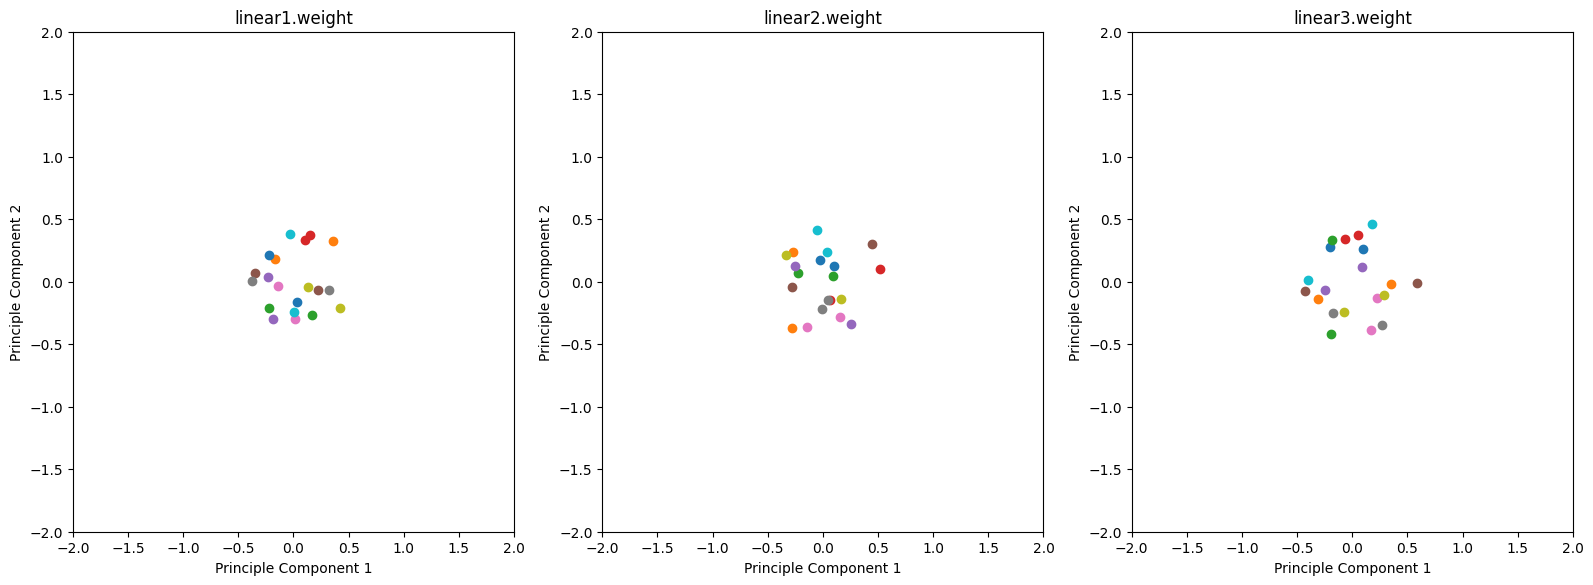

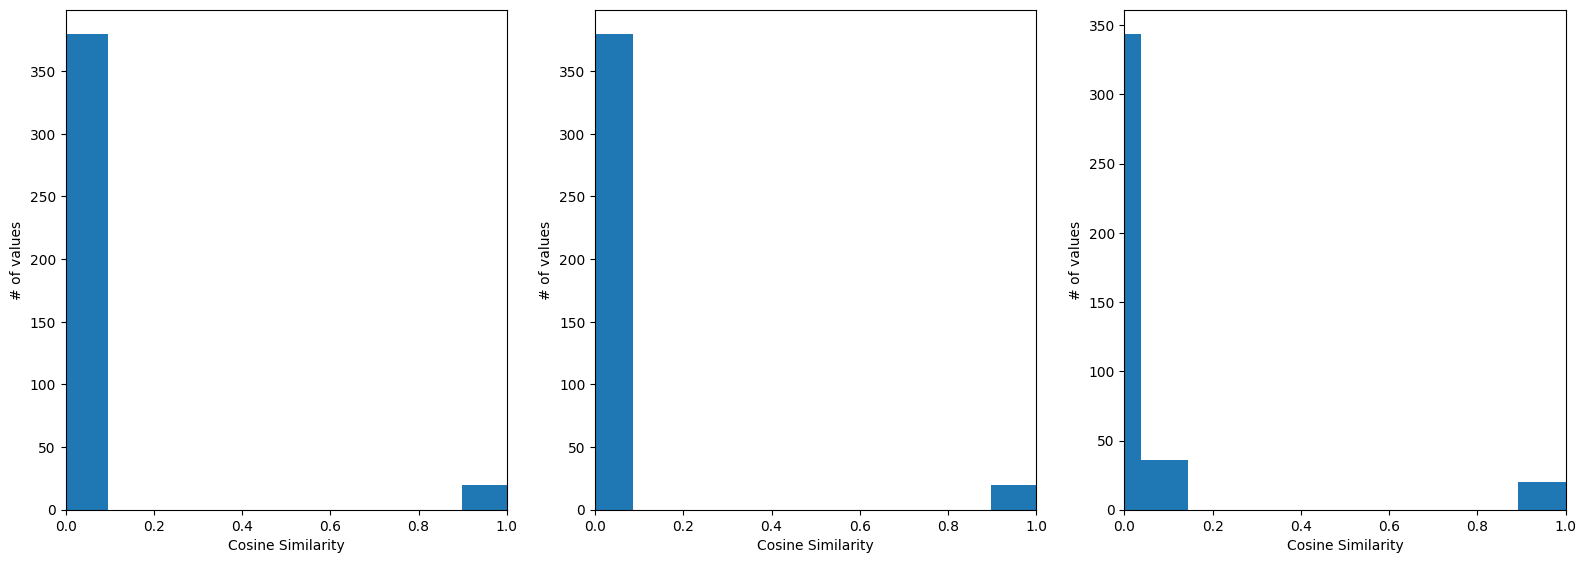

[91.87, 91.8, 91.78, 91.72, 91.68, 91.67, 91.65, 91.64, 91.62, 91.62, 91.61, 91.6, 91.58, 91.56, 91.49, 91.47, 91.45, 91.43, 91.42, 91.36]
Generation 1


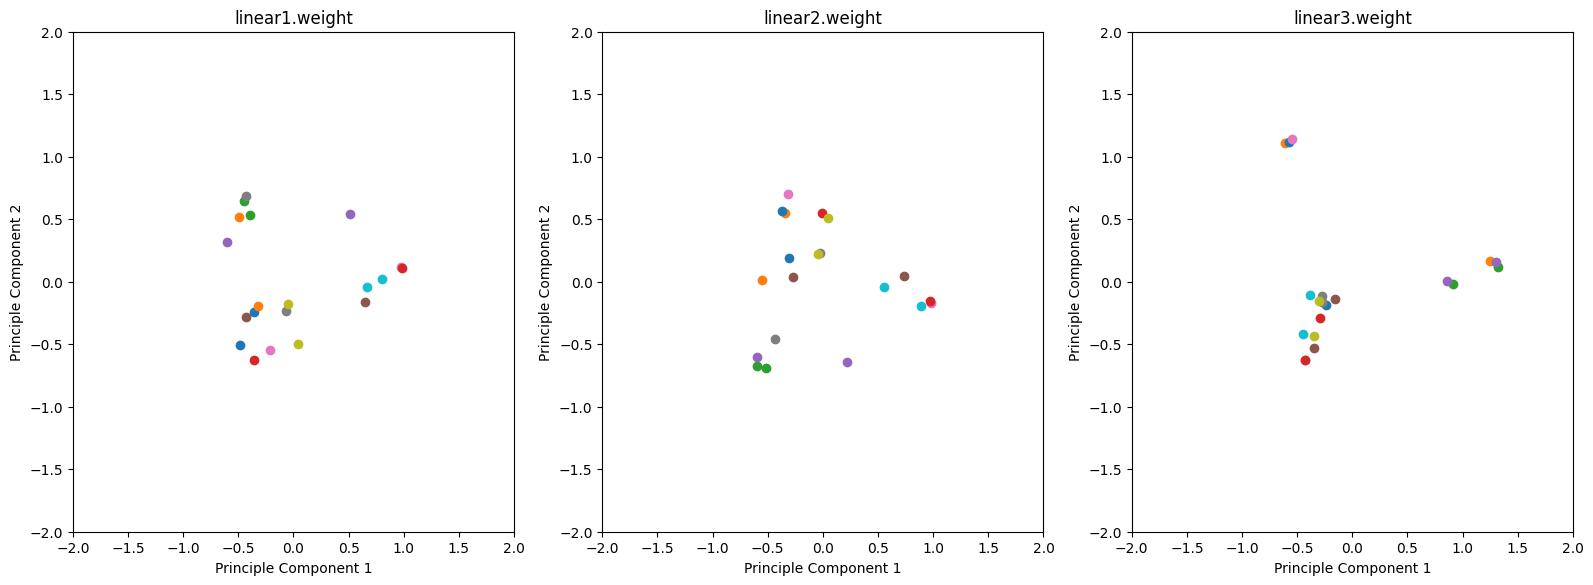

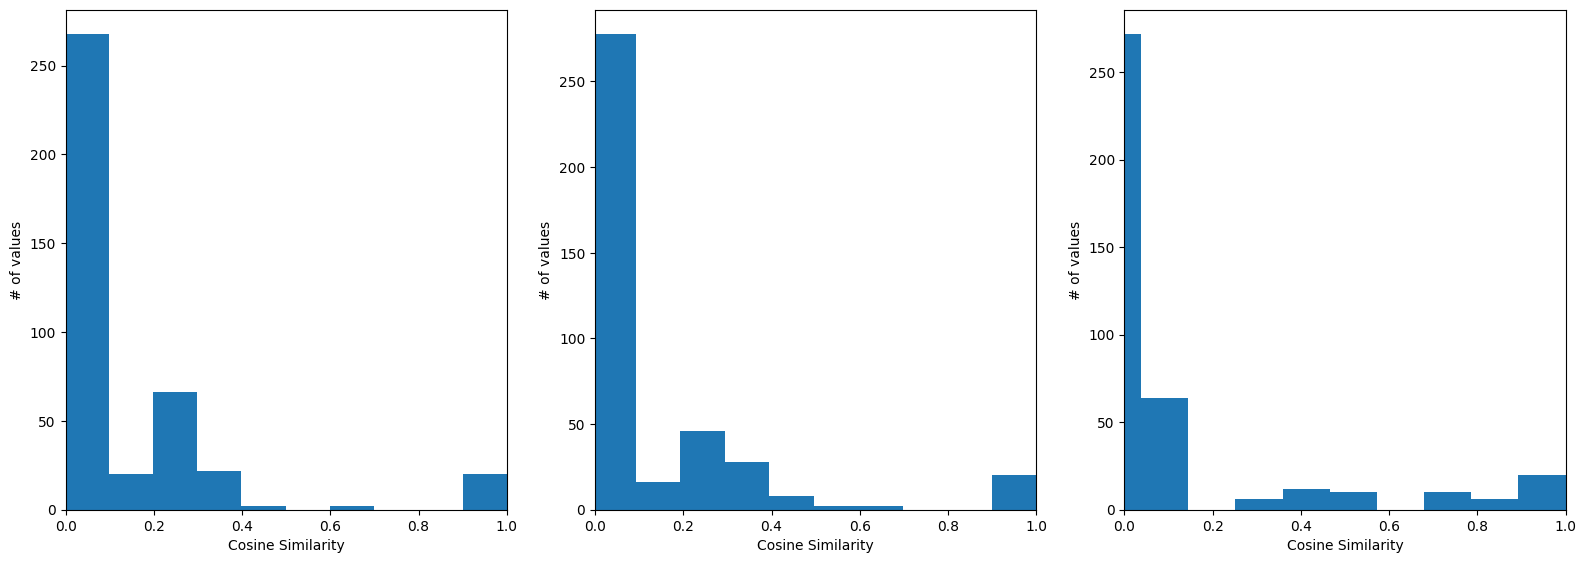

[93.89, 93.74, 93.69, 93.62, 93.49, 93.47, 93.45, 93.44, 93.4, 93.37, 93.32, 93.3, 93.3, 93.27, 93.25, 93.22, 93.21, 93.19, 92.97, 92.89]
Generation 2


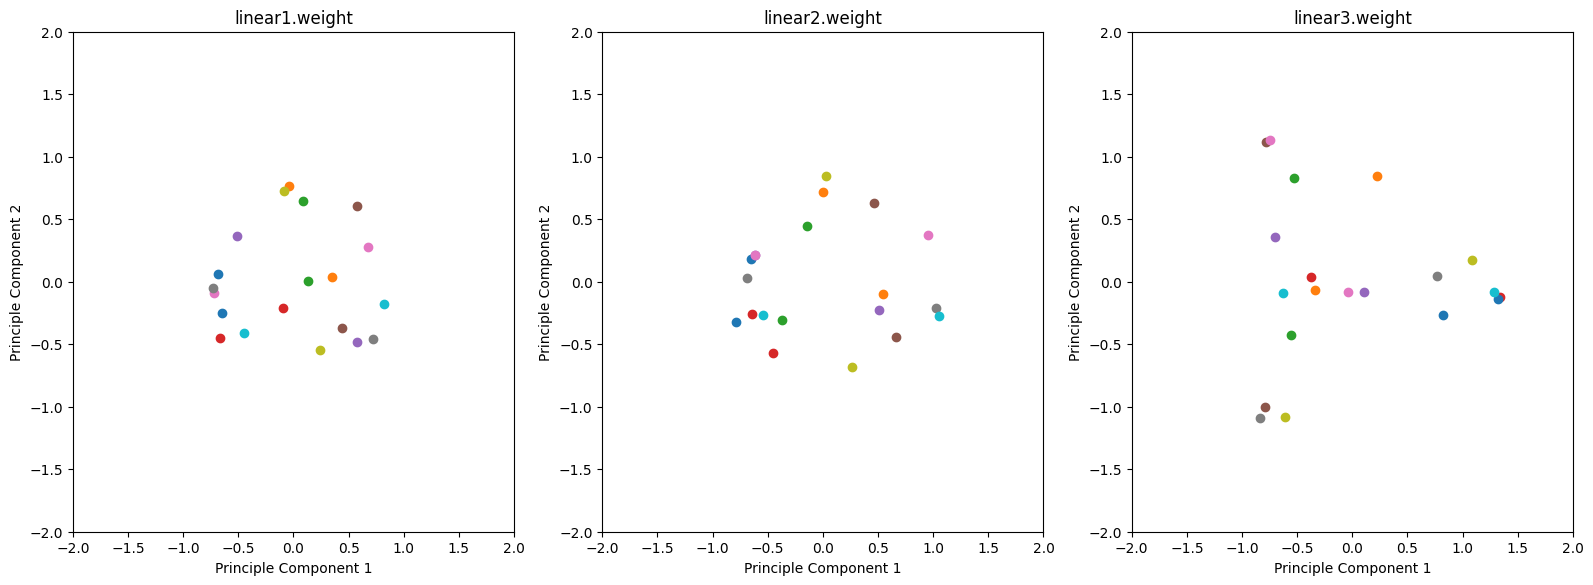

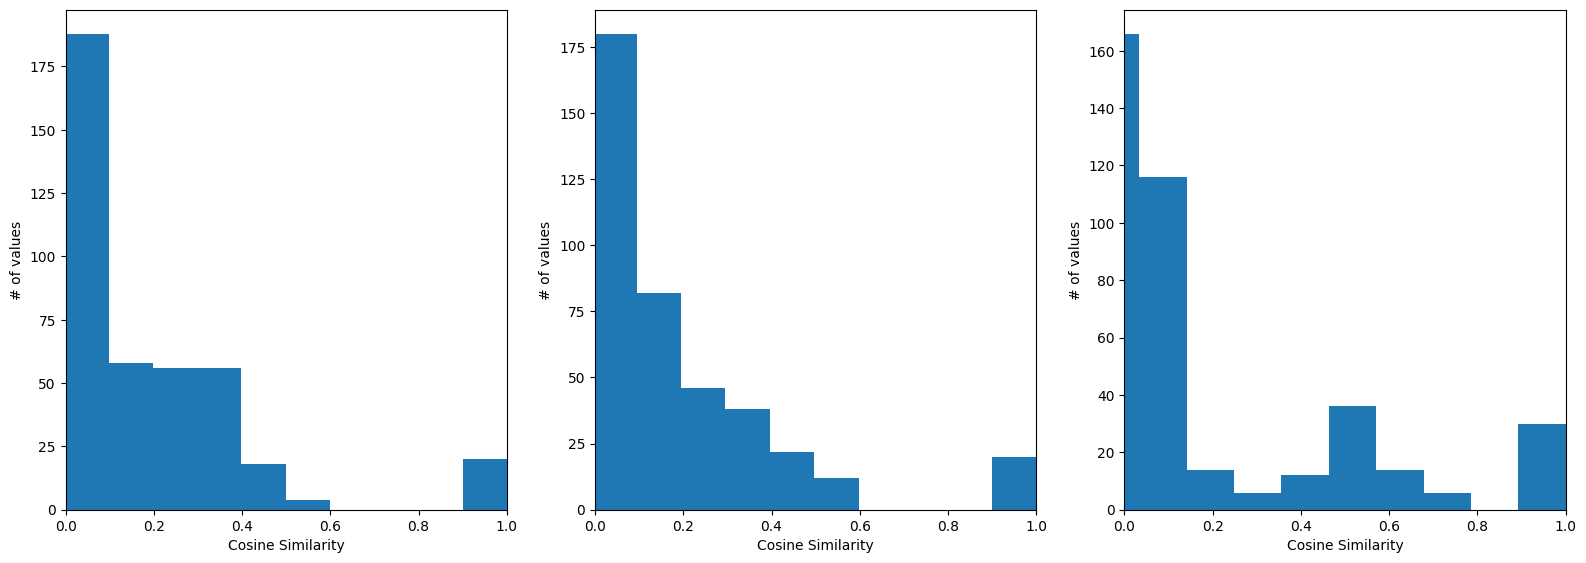

[94.96, 94.91, 94.88, 94.79, 94.77, 94.74, 94.74, 94.73, 94.65, 94.58, 94.52, 94.48, 94.47, 94.46, 94.46, 94.45, 94.4, 94.38, 94.31, 94.15]
Generation 3


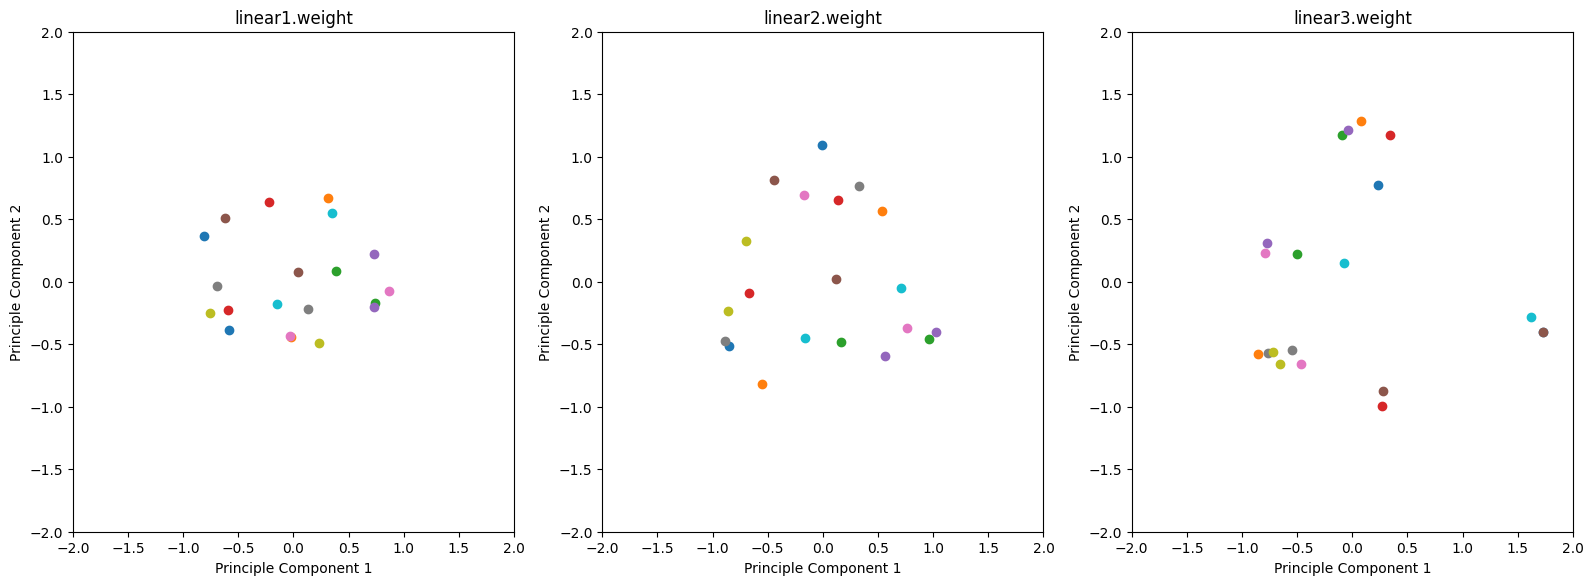

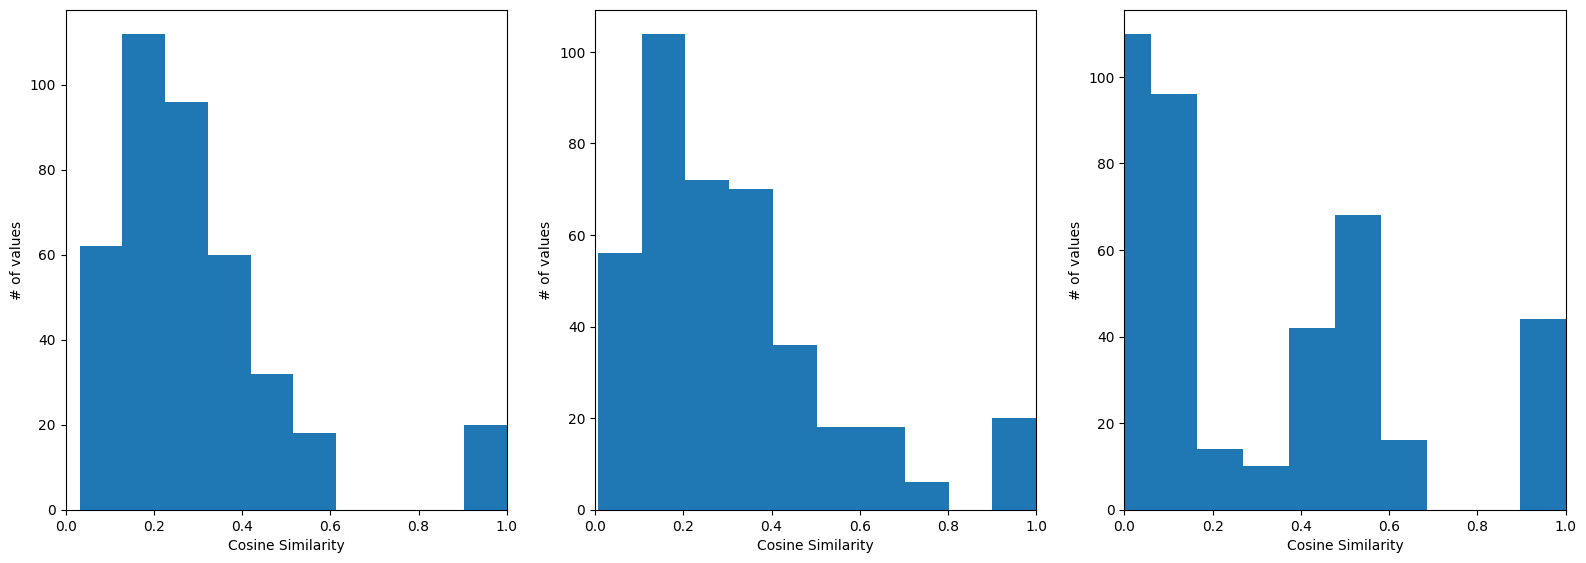

[95.9, 95.81, 95.69, 95.59, 95.58, 95.51, 95.44, 95.42, 95.41, 95.41, 95.35, 95.32, 95.3, 95.27, 95.17, 95.1, 95.08, 94.91, 94.87, 94.68]
Generation 4


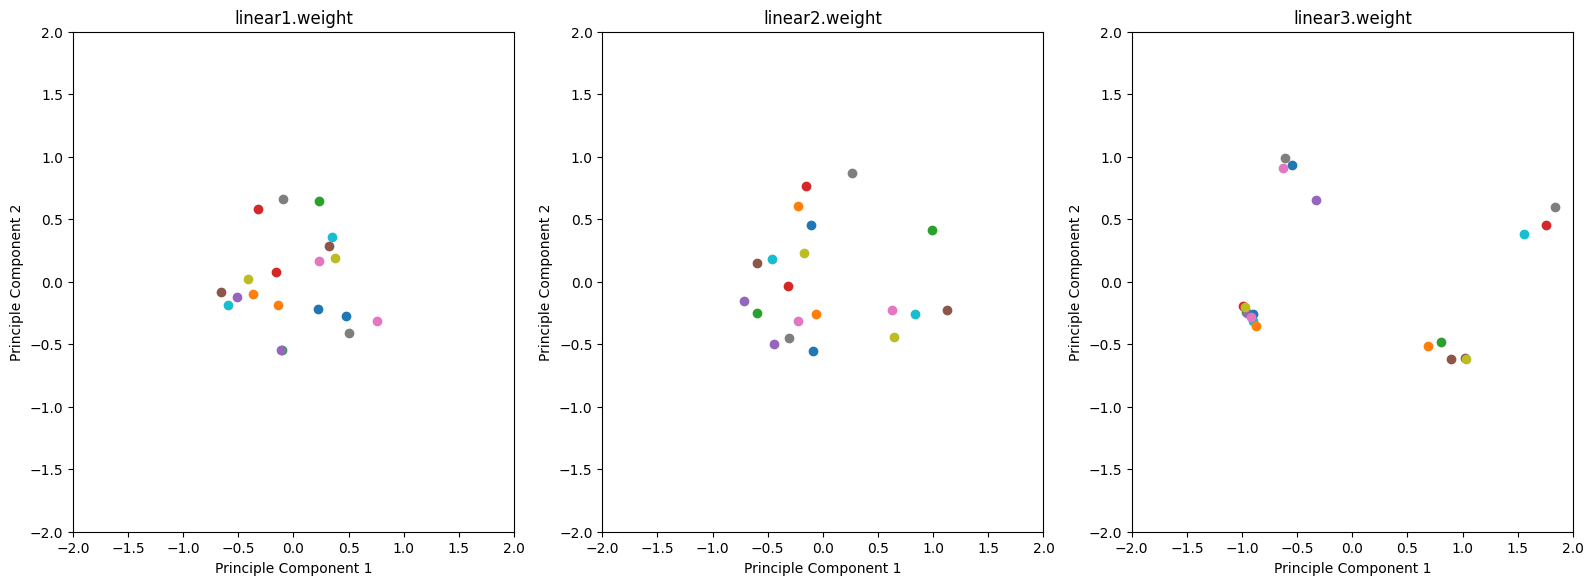

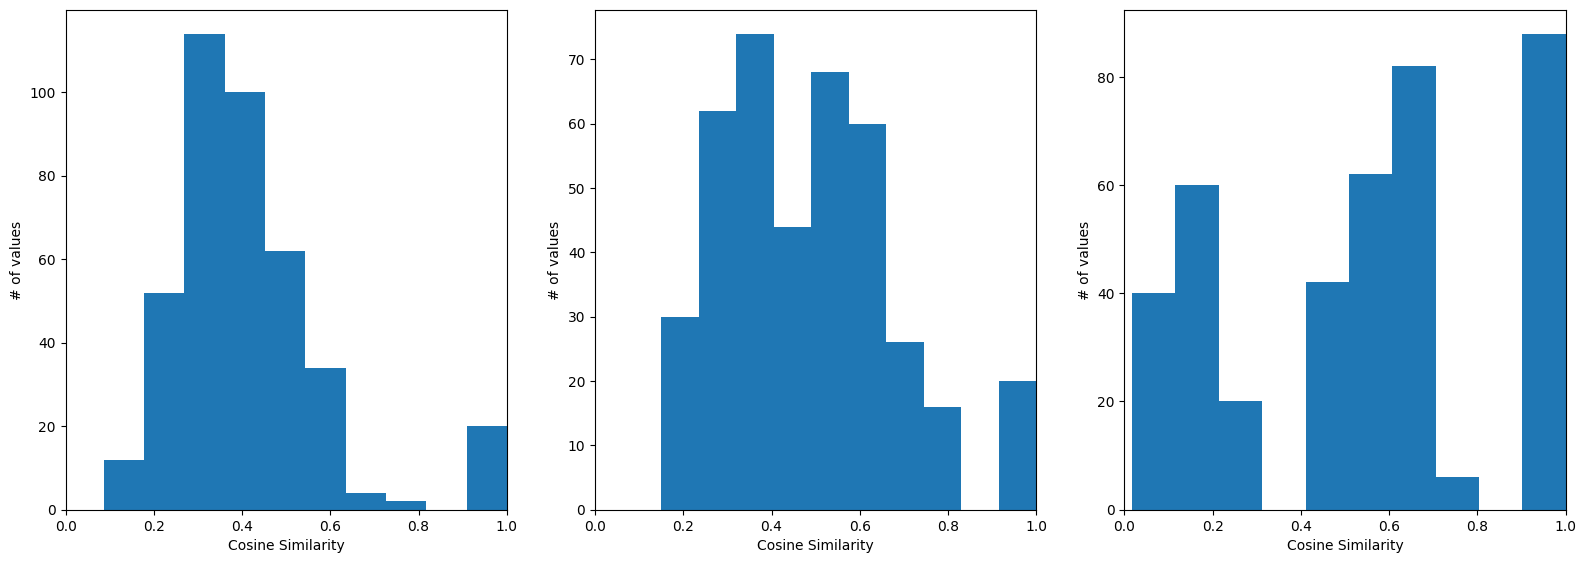

[96.58, 96.33, 96.31, 96.28, 96.2, 96.18, 96.16, 96.11, 96.02, 96.0, 95.93, 95.91, 95.88, 95.84, 95.84, 95.84, 95.79, 95.77, 95.73, 95.69]
Generation 5


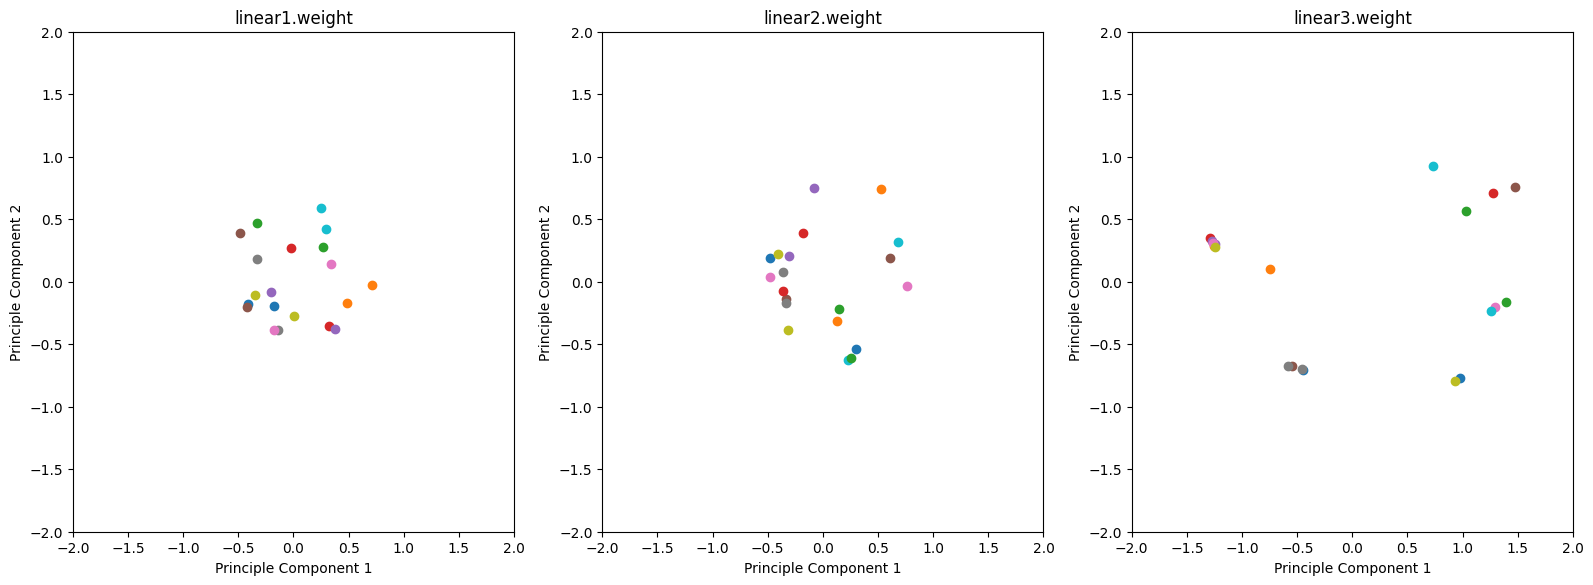

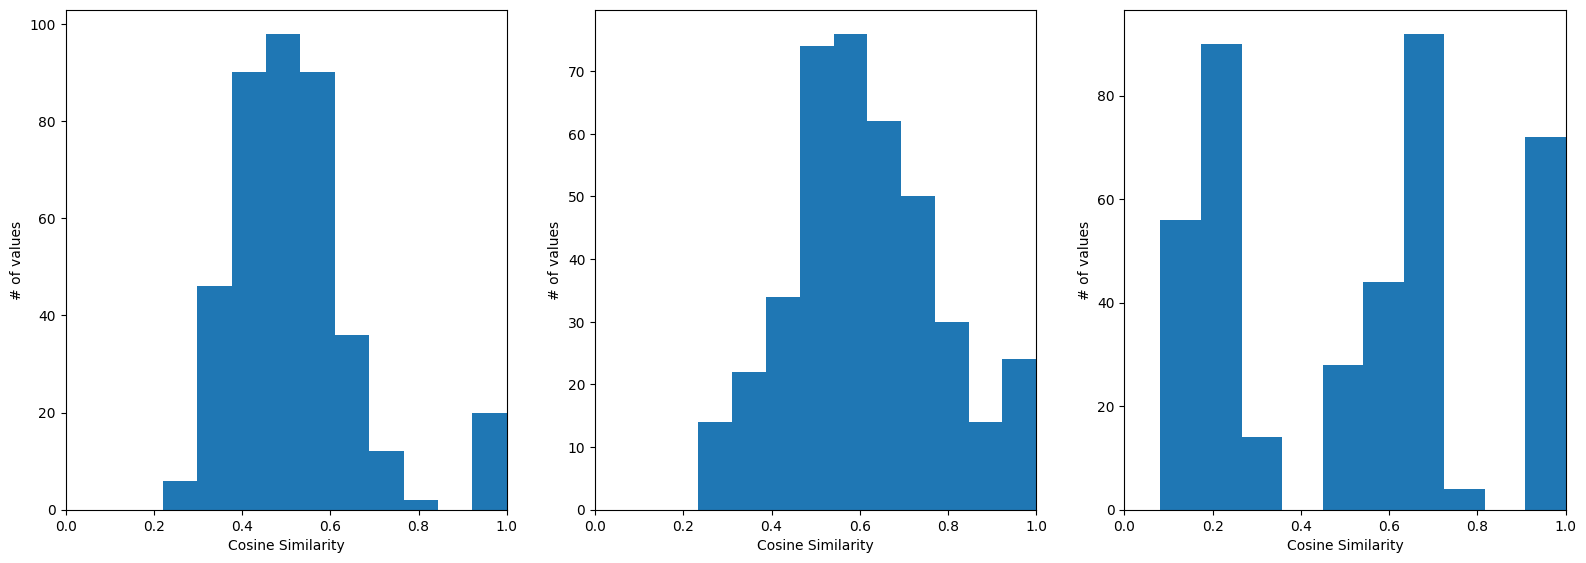

[96.91, 96.89, 96.83, 96.79, 96.75, 96.73, 96.7, 96.63, 96.59, 96.58, 96.57, 96.55, 96.51, 96.5, 96.5, 96.46, 96.39, 96.36, 96.34, 96.19]
Generation 6


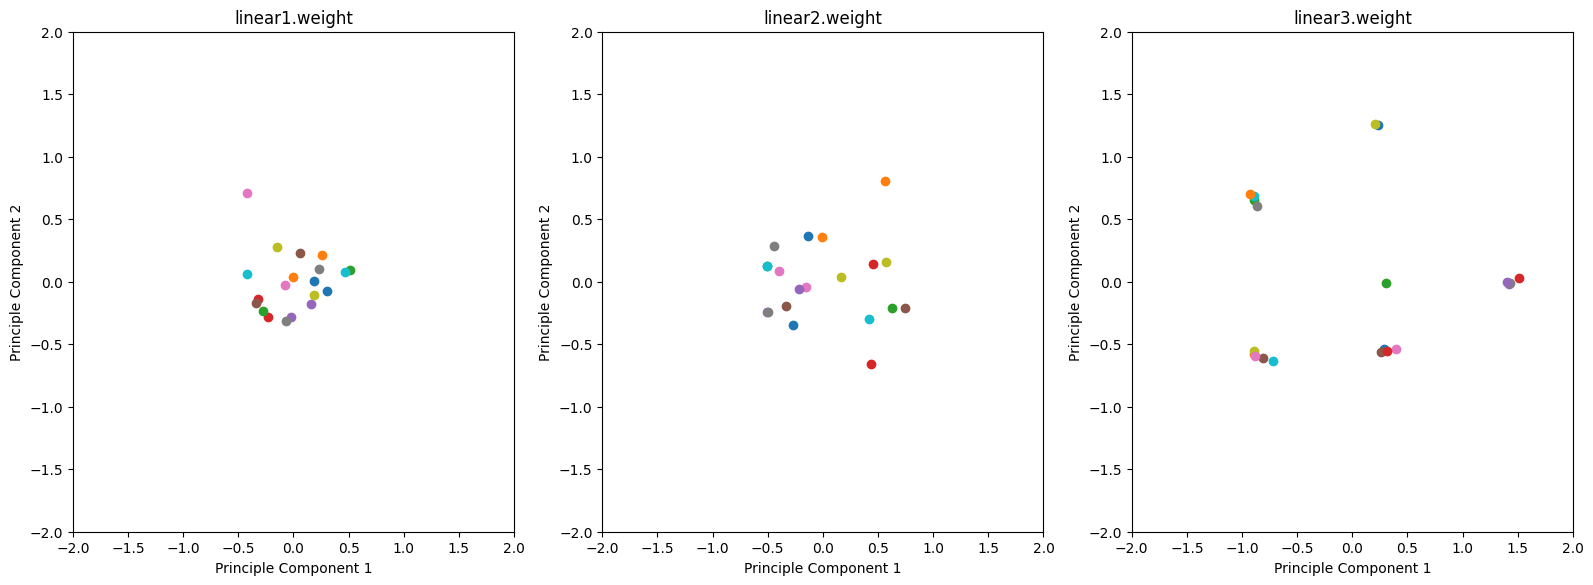

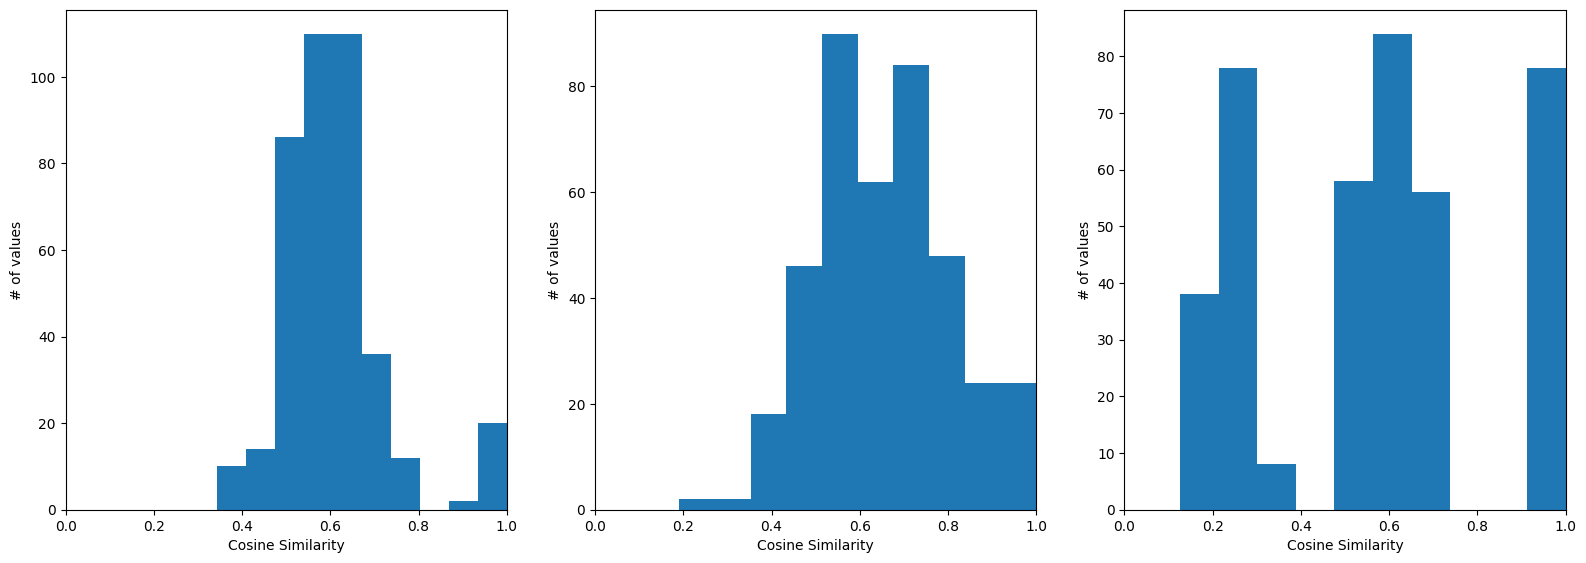

In [ ]:
pop.simulate(train_loader, test_loader, device, optimizer, args)

# Simulate Pop with Vertical Genes

In [ ]:
pop2 = Population(ModelClass=VerticalGeneticNet, population_size=20, expansion_factor=2, learning_epochs=1, num_generations=6, new_fraction=0.1)


args = Namespace()
args.log_interval = 100
args.dry_run = False

train_dataset = train_data
train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    num_workers=1
)

test_dataset = test_data
test_loader = DataLoader(
    test_dataset,
    batch_size=100,
    num_workers=1
)

optimizer = optim.SGD



This section performs very similar to the horizontal gene population above, refer to that for a brief description of what the output means.

The main difference here is the vertical split in the second layer, which adds an extra graph to each set.

In general both populations perform very similarly, sometimes the cosine similarity values converge to 1 faster in one versus the other but so far this seems to be random.

Generation 0


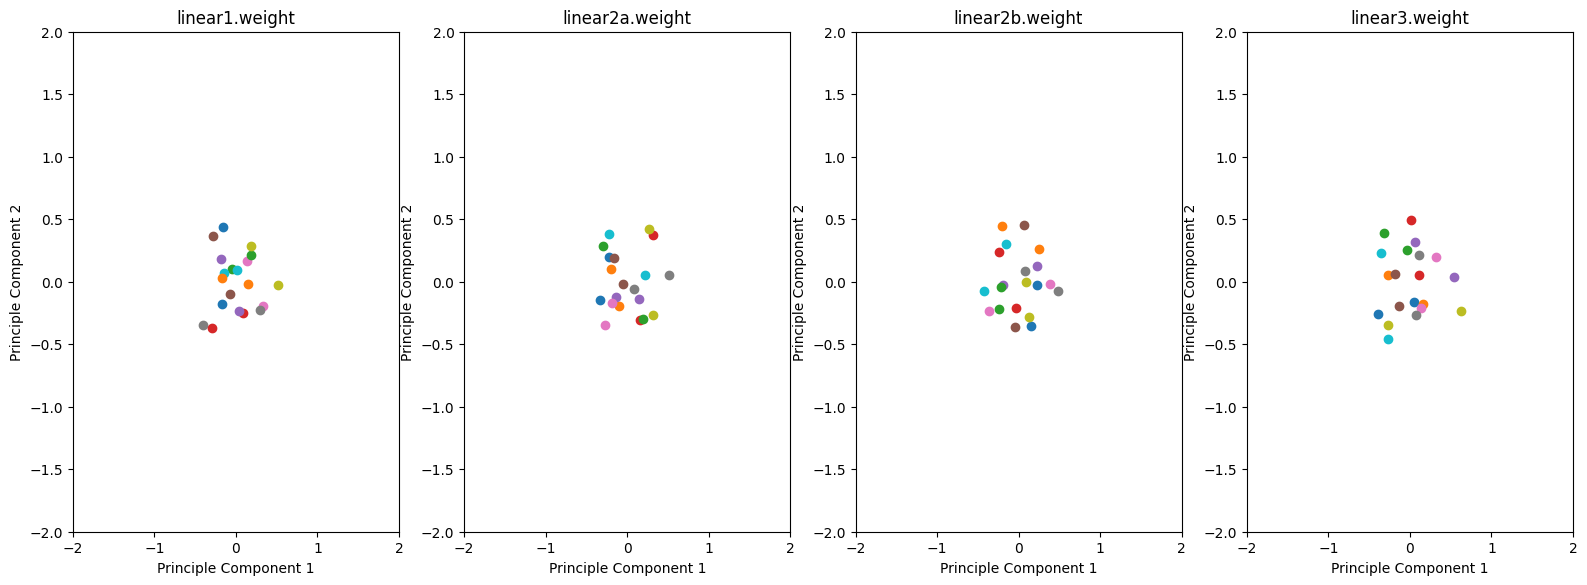

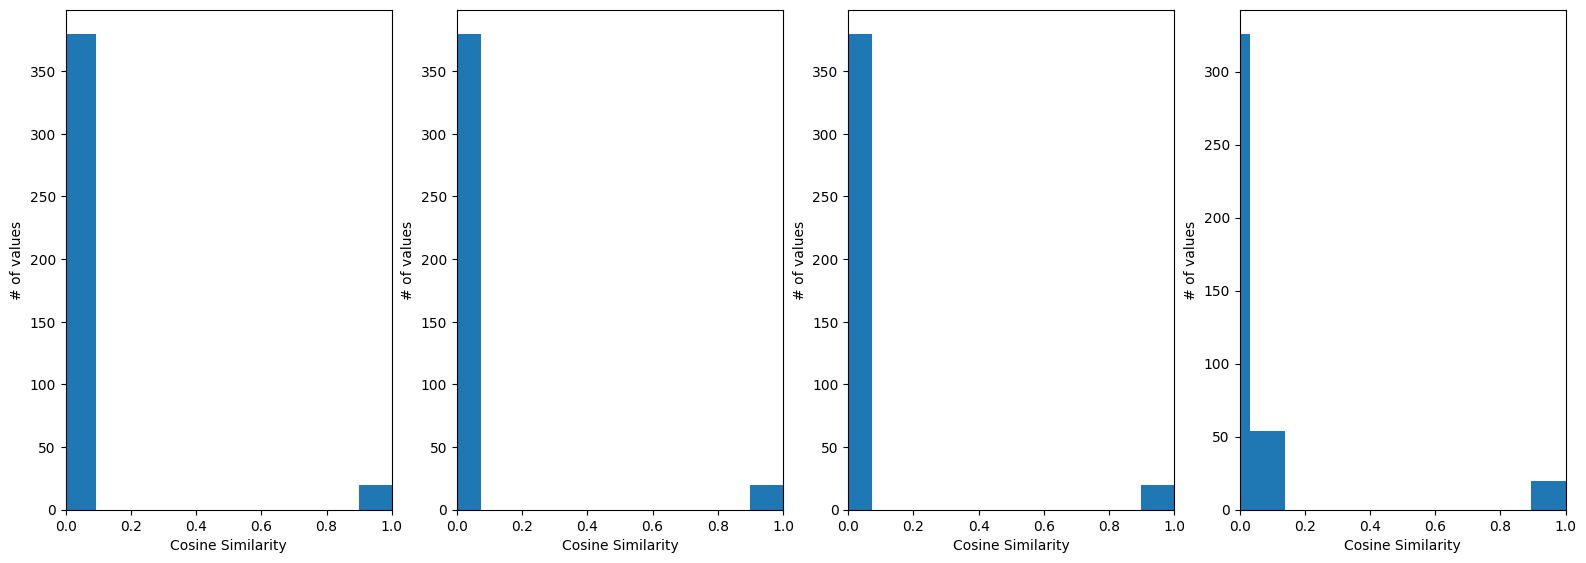

[91.64, 91.64, 91.62, 91.58, 91.58, 91.57, 91.57, 91.55, 91.53, 91.52, 91.51, 91.49, 91.49, 91.48, 91.44, 91.34, 91.34, 91.33, 91.28, 91.08]
Generation 1


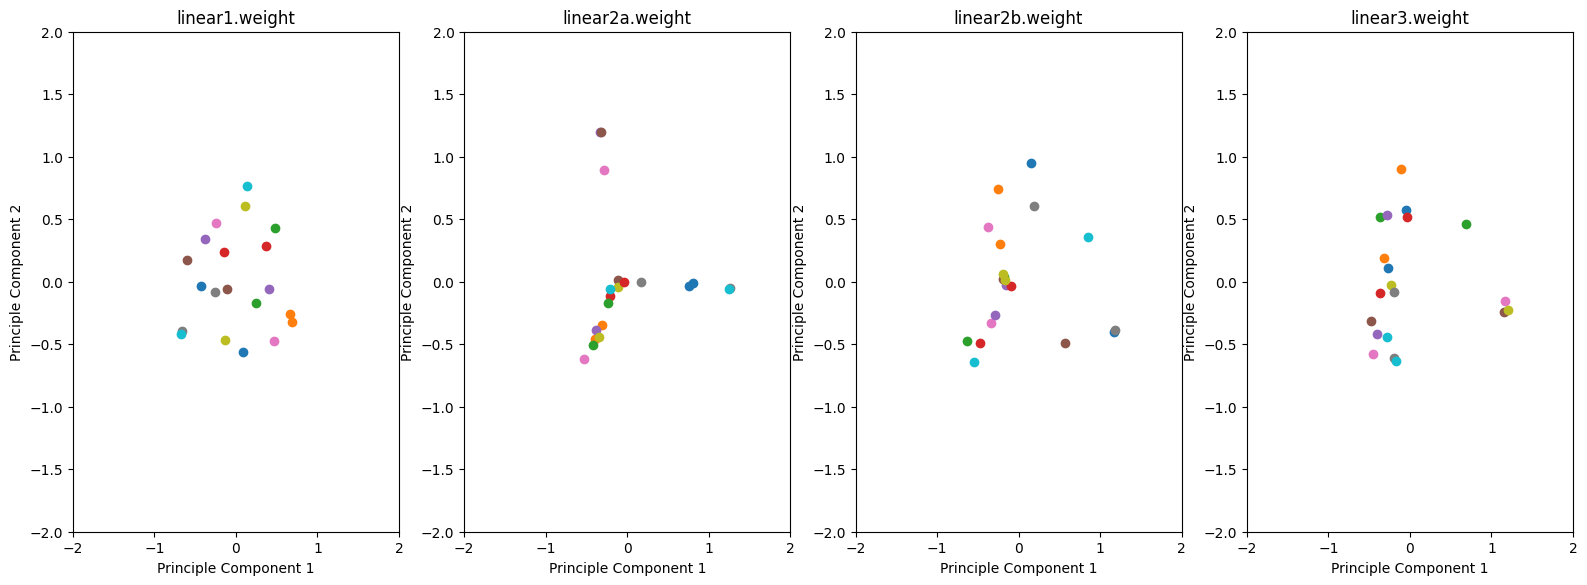

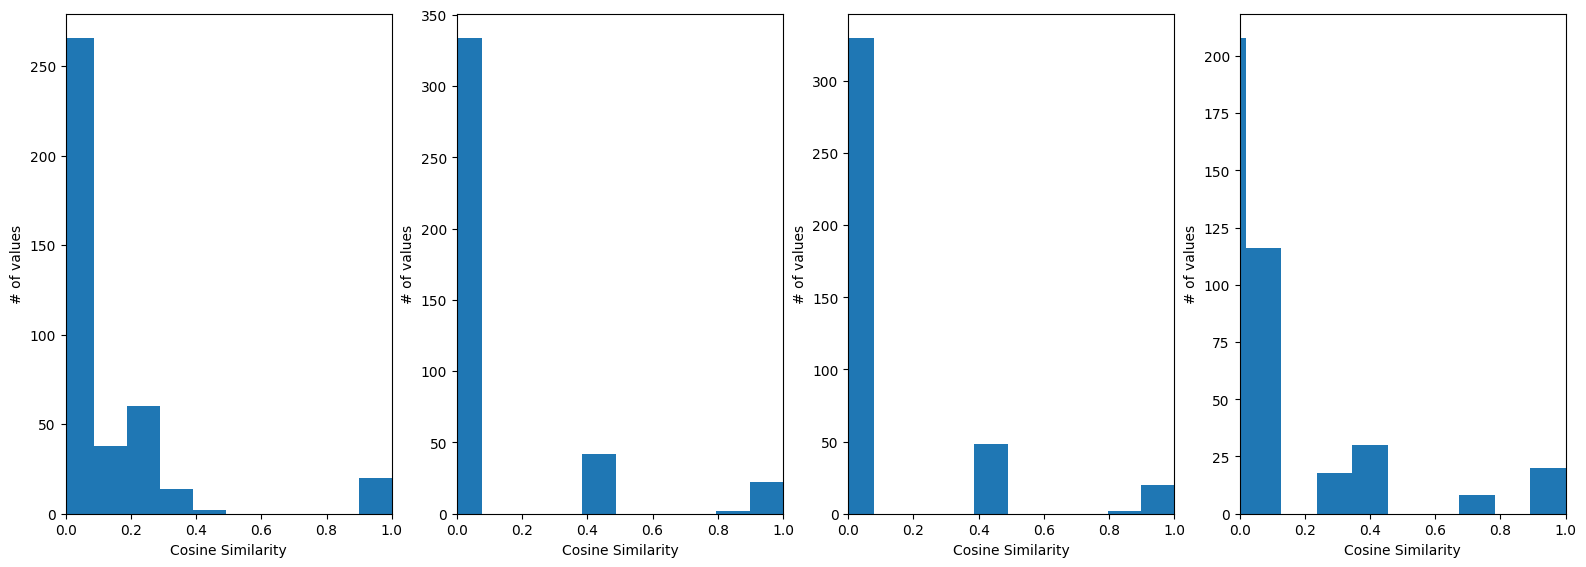

[93.84, 93.53, 93.51, 93.42, 93.37, 93.32, 93.25, 93.23, 93.22, 93.22, 93.21, 93.19, 93.08, 93.06, 93.05, 93.05, 93.02, 92.88, 92.81, 92.68]
Generation 2


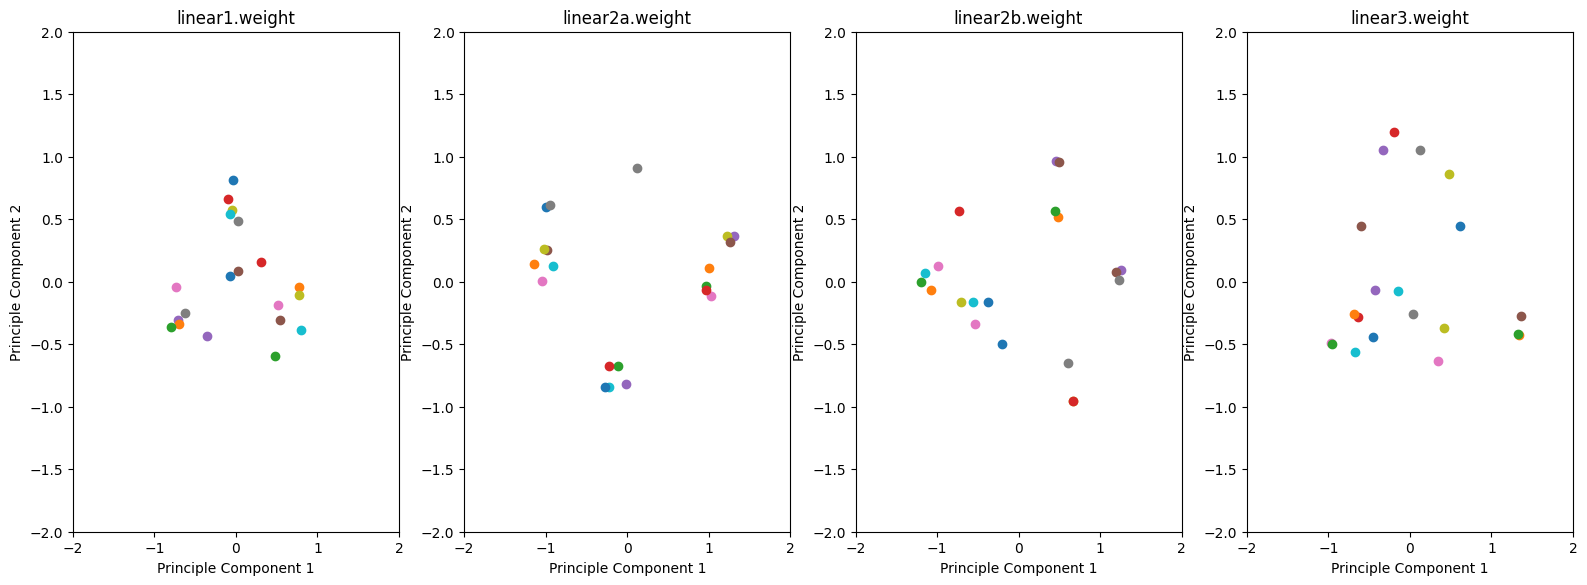

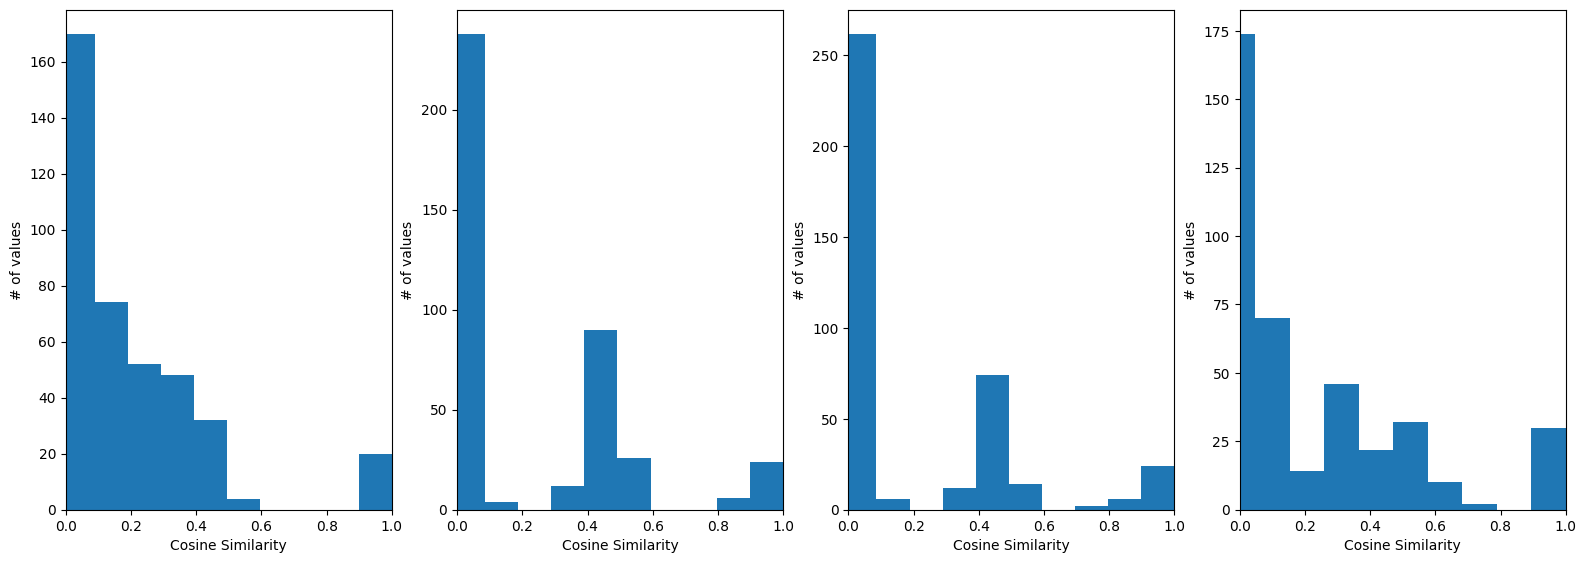

[94.83, 94.82, 94.66, 94.63, 94.59, 94.55, 94.51, 94.49, 94.48, 94.32, 94.31, 94.27, 94.26, 94.24, 94.24, 94.21, 94.15, 93.88, 93.77, 93.71]
Generation 3


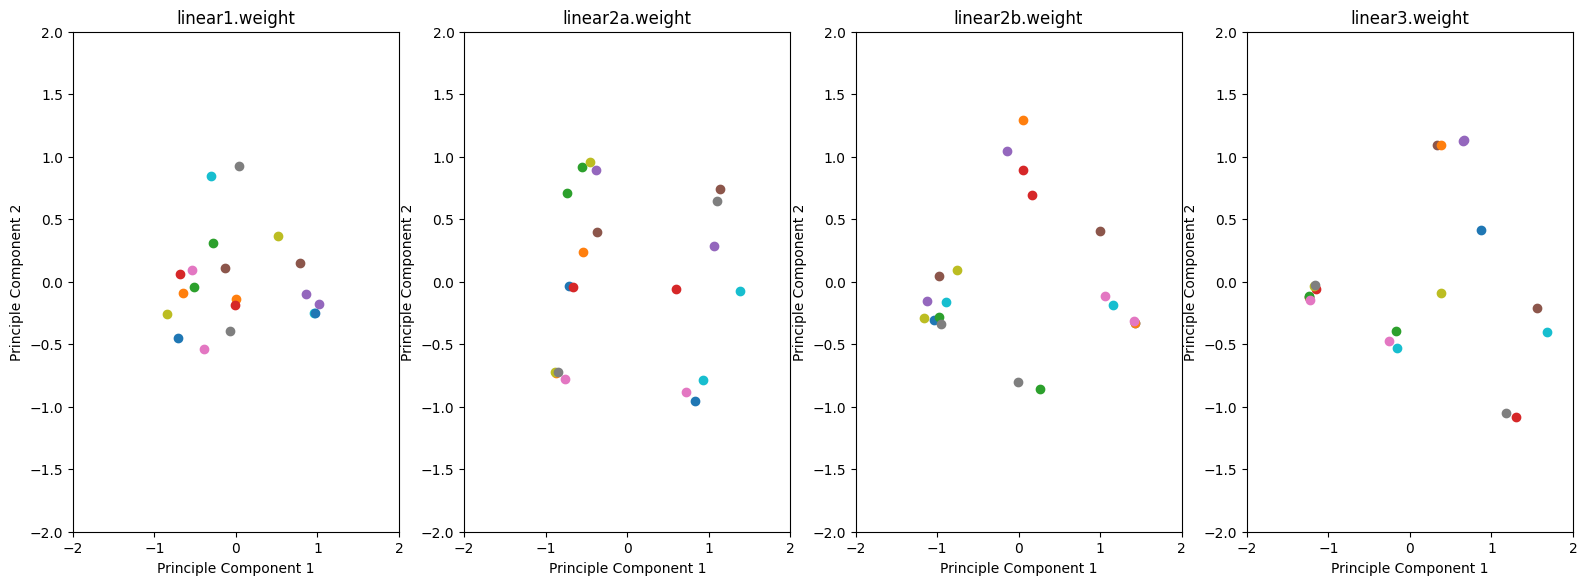

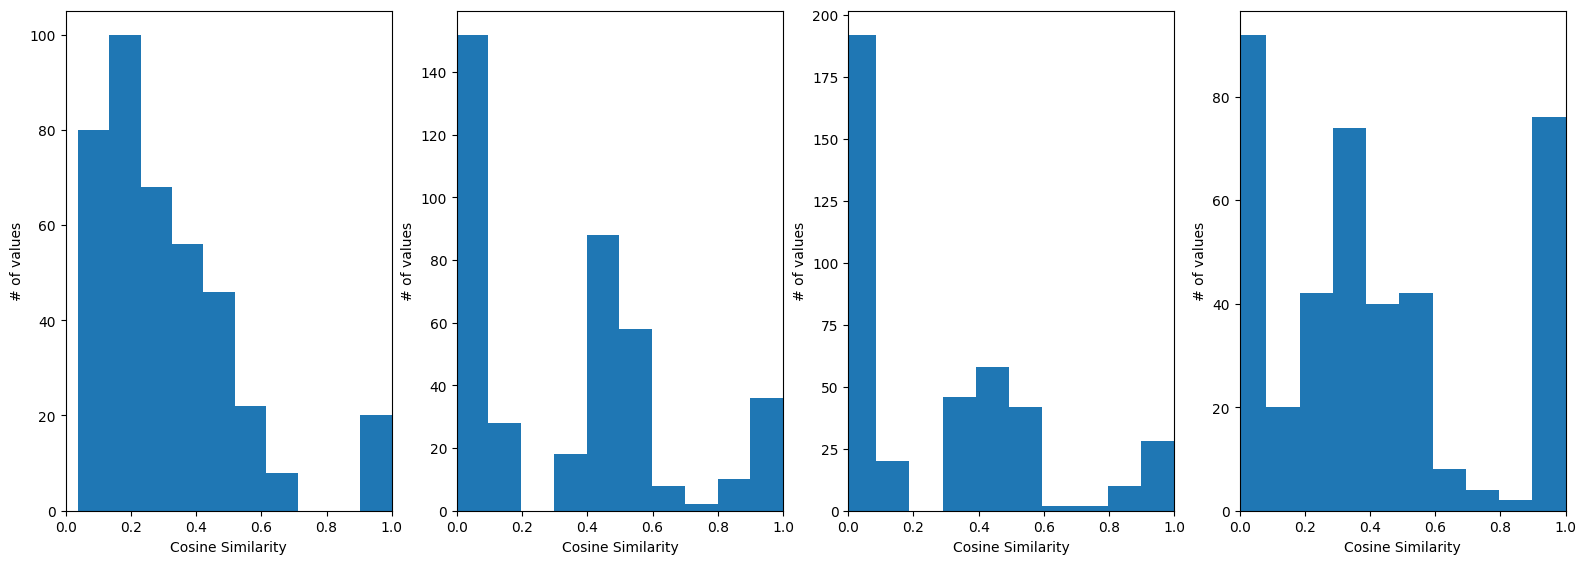

[95.8, 95.71, 95.63, 95.55, 95.5, 95.5, 95.46, 95.4, 95.19, 95.13, 95.12, 95.03, 95.02, 94.99, 94.98, 94.94, 94.86, 94.75, 94.67, 94.6]
Generation 4


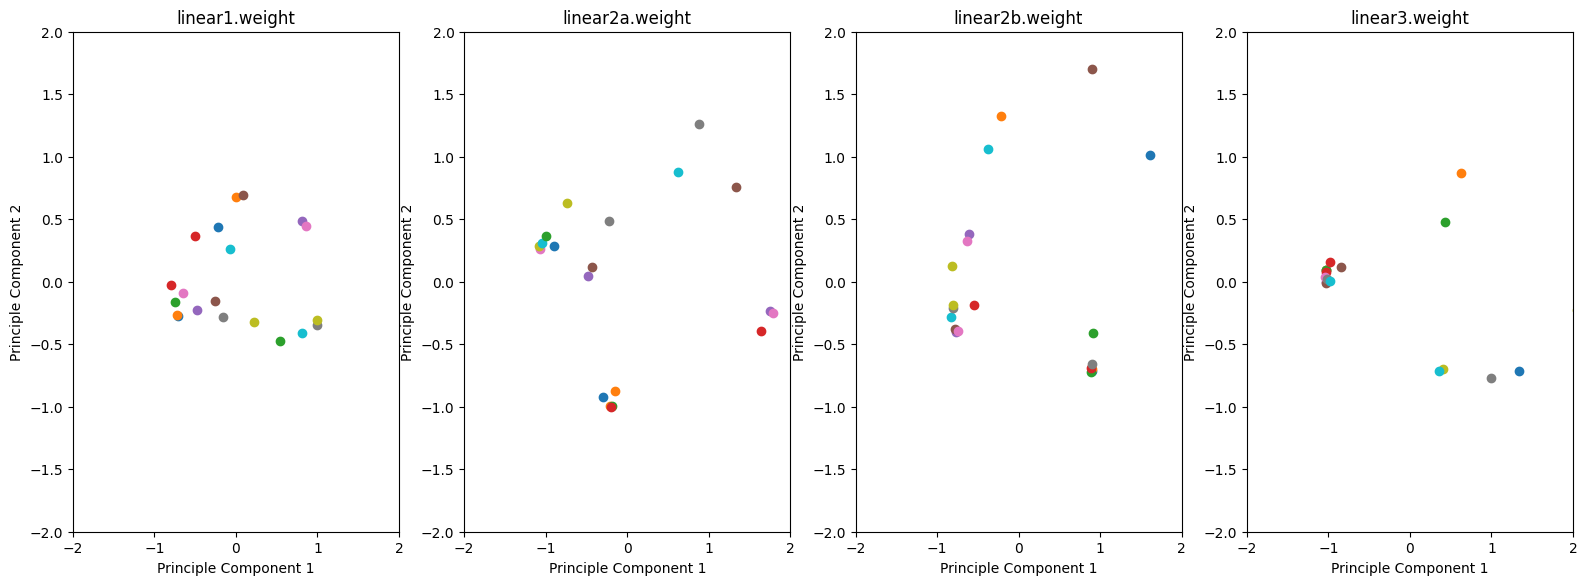

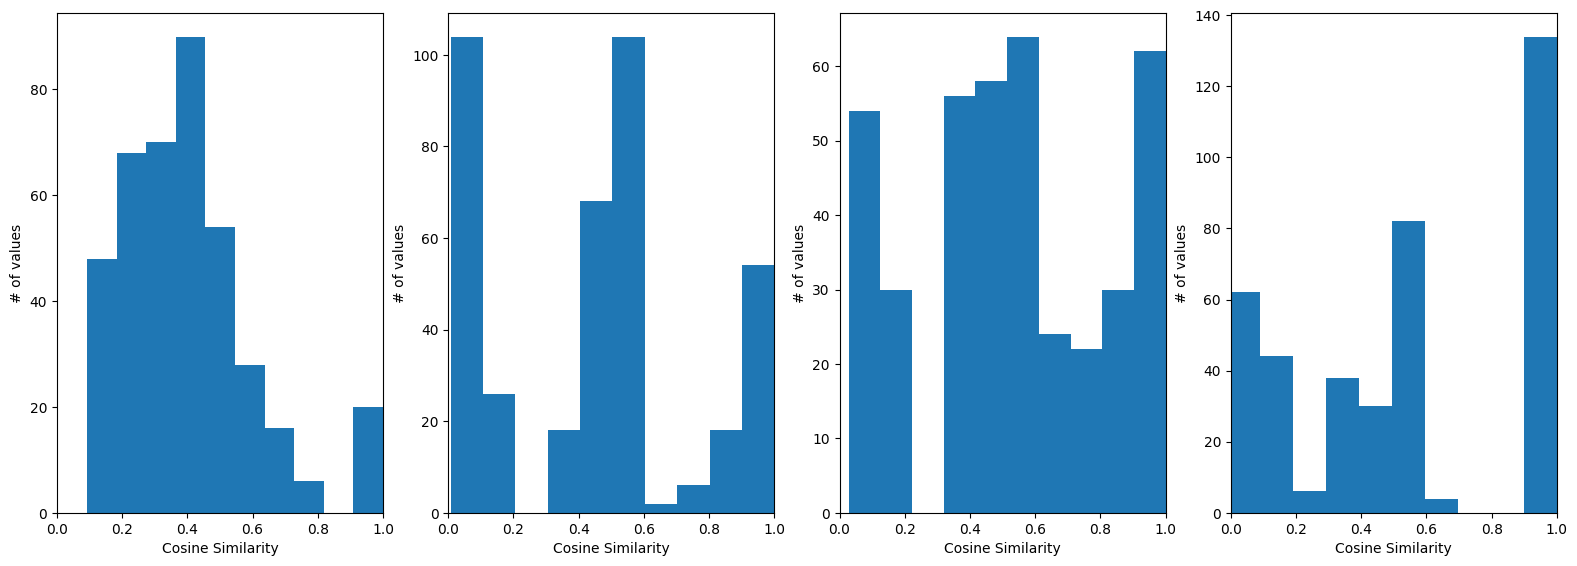

[96.38, 96.34, 96.34, 96.29, 96.26, 96.19, 96.14, 96.11, 96.07, 96.07, 96.05, 96.04, 96.04, 96.01, 96.0, 96.0, 95.87, 95.71, 95.59, 95.55]
Generation 5


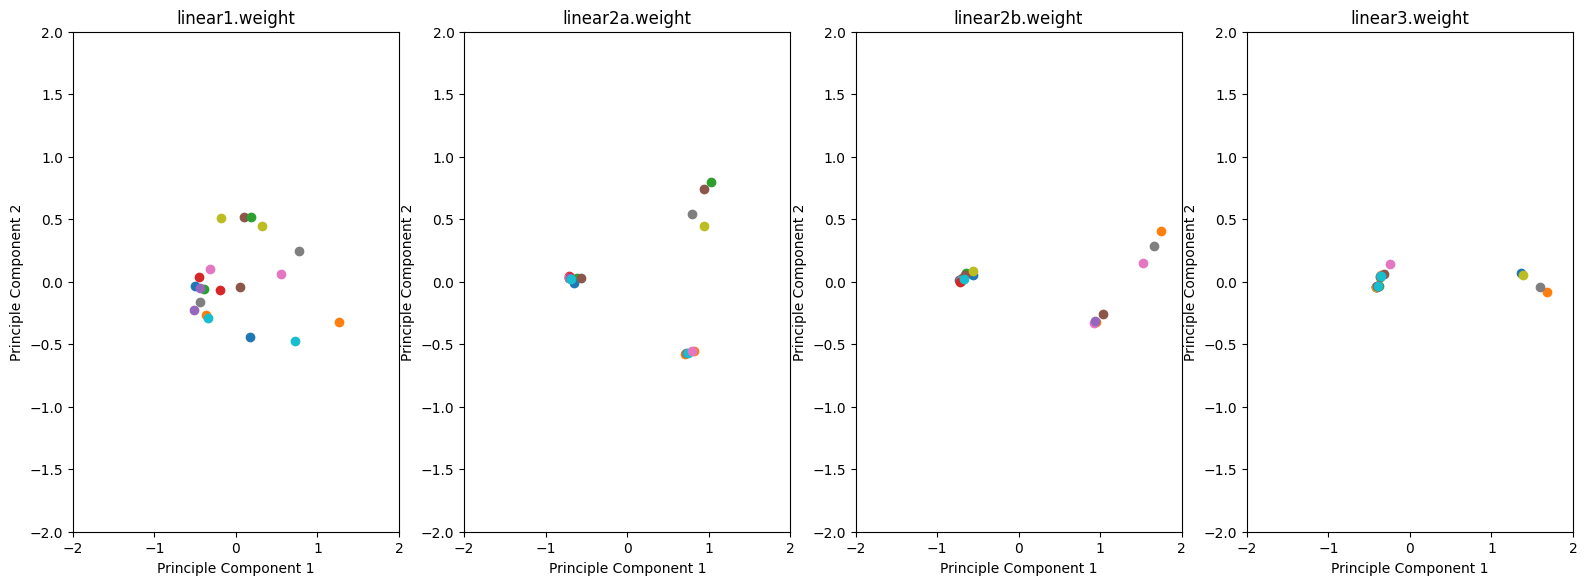

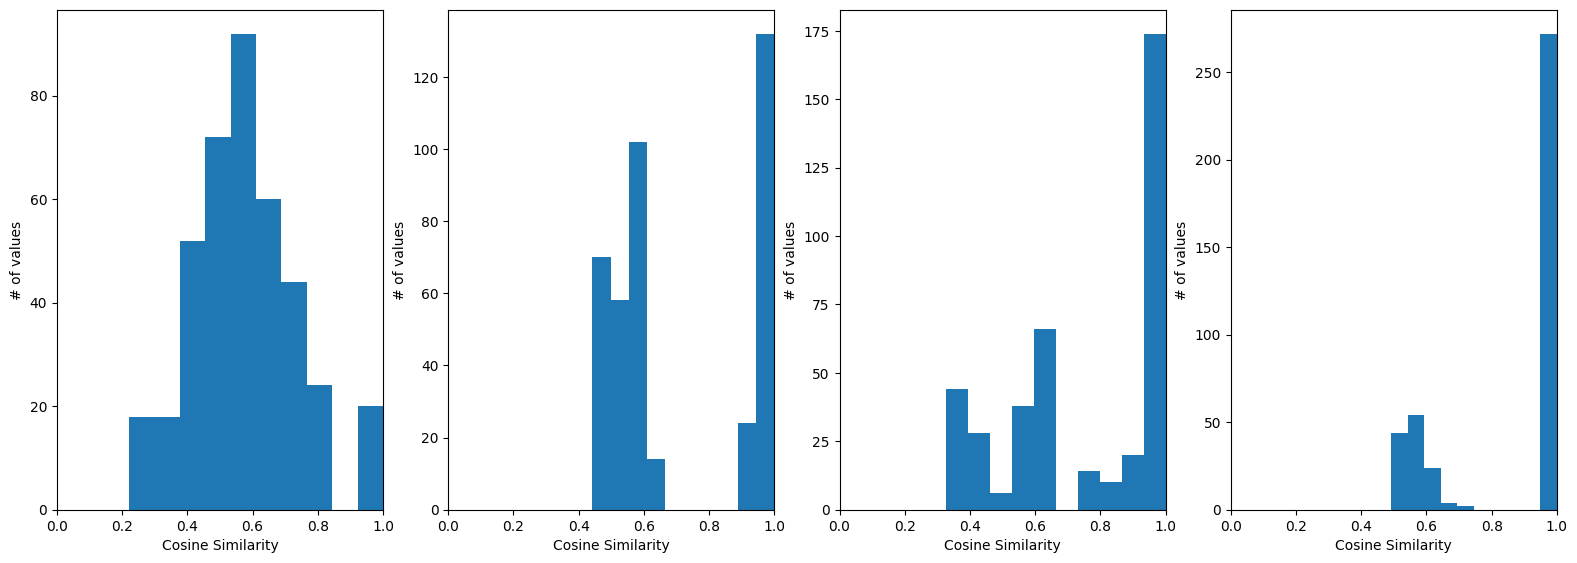

[96.87, 96.77, 96.74, 96.73, 96.71, 96.71, 96.66, 96.62, 96.6, 96.6, 96.6, 96.58, 96.55, 96.51, 96.49, 96.45, 96.44, 96.43, 96.33, 96.29]
Generation 6


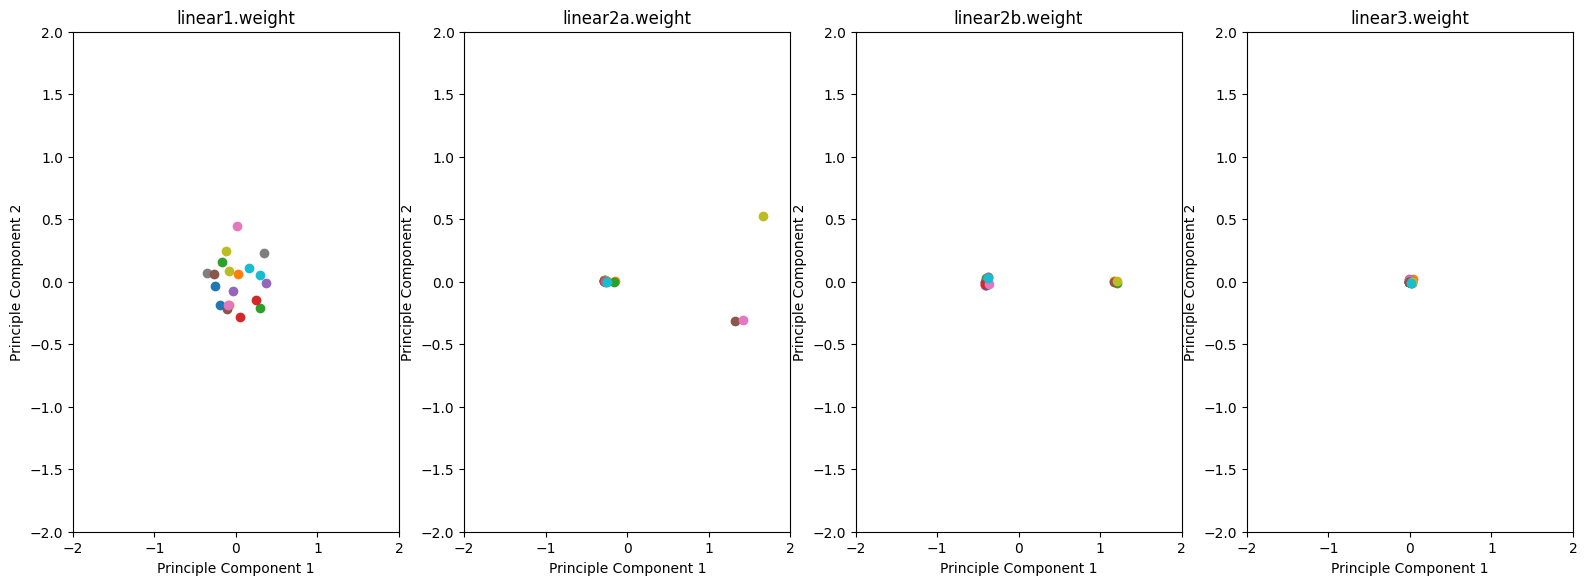

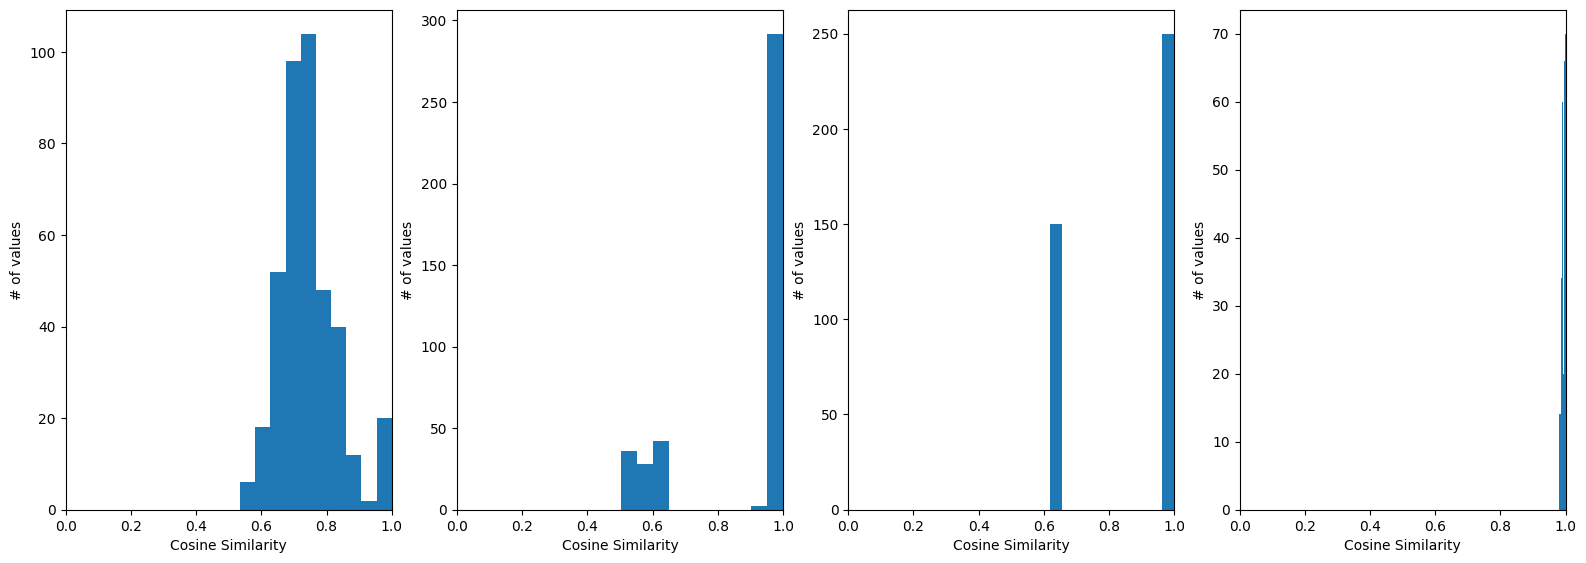

In [ ]:
pop2.simulate(train_loader, test_loader, device, optimizer, args)

# Adversarial Attack Setup

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

Here is the main function used to perform adversarial attacks. This is mostly a standard fgsm adversarial attack method. The main modification is that it takes two models as input, given_model and target_model respectively. The purpose of this method is to be able to develop an attack on one model and test its performance against another. If both given_model and target_model are the same it is identical to the standard fgsm method which trains on and attacks the same model.

The given_model parameter corresponds to the model which is used to generate the attack. The method looks as the prediction this model gives and uses its loss to modify the input in a way which increases this loss.

The target_model parameter is the target of the adversarial attack. Once the data is modified according to the given_model's prediction, it is given to the target_model and its predictions are used to determine the accuracy of the model under this attack.

The device parameter is the device used for computation, generally just the colab cpu in these experiments.

The test_loader parameter used for this function has one key difference compared to the test loaders used elsewhere in the code, the batch size for this test loader is 1. This impacts performance but it is necessary for the code as it is written here to properly transform the data for the attack.

The epsilon parameter corresponds to how much the input data is modified for the attack. The higher the value, the more the data is distorted. In these experiments, the epsilon value of 0.05 was used.

In [ ]:
# creates attack using given model and then tests it against target model
def fgsm_test( given_model, target_model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = given_model(data.flatten(start_dim=1))

        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        perturbed_data_normalized = data
        if init_pred.item() == target.item():
            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero all existing gradients
            given_model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect ``datagrad``
            data_grad = data.grad.data

            # Restore the data to its original scale
            data_denorm = denorm(data)

            # Call FGSM Attack
            perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

            # Reapply normalization
            perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = target_model(perturbed_data_normalized.flatten(start_dim=1))

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))

    # Return the accuracy and an adversarial example
    return final_acc

In [ ]:
epsilons = [.05]

test_dataset = test_data
adv_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=1
)

# Adversarial Attack on Pop With Horizontal Genes

These first two cells test the resilience of the final population against adversarial attack.

Specifically, the attack is generated using the best (most accurate) model from the final generation and is then tested against each model in the final generation.

The each element of the list printed out below is the accuracy of each model under attack for the given epsilon values. The element will be lower than the rest since it is the performance of the best model, which is being used to generate the attack.

In general, the attack generalizes very well to the other models in the final generation. Accuracies generally stay in the 1-4% range.

In [ ]:
# get the performance of each model in the final pop for adversarial attack

pop_acc = []
for individual in pop.population:
  ind_acc = []
  for eps in epsilons:
    acc = fgsm_test(pop.population[0], individual, device, adv_loader, eps)
    ind_acc.append(acc)
  pop_acc.append(ind_acc)

In [ ]:
print(pop_acc)

[[0.0061], [0.0303], [0.0219], [0.0299], [0.0296], [0.0241], [0.019], [0.0274], [0.0326], [0.022], [0.0322], [0.0353], [0.04], [0.0355], [0.0283], [0.0414], [0.0382], [0.0347], [0.0332], [0.0433]]


In these next two code blocks, a new model is assembled, each layer is taken at random from the final population and then it is tested with the same attack method as above. The value printed out at the end is the accuracy of the new model when attacked.

As the model is not trained after this recombination its standard accuracy is a bit low, around 75% or so. It does not seem to perform significantly better under attack than the models from the final generation.

In [ ]:
# Get performance of a random combination of layers from the final population

i = random.randint(0, len(pop.population)-1)
j = random.randint(0, len(pop.population)-1)
k = random.randint(0, len(pop.population)-1)

m1 = pop.population[i]
m2 = pop.population[j]
m3 = pop.population[k]

child = copy.deepcopy(m1)

# Recombines the parameters.

child.state_dict()['linear2.weight'].copy_(m2.state_dict()['linear2.weight'])
child.state_dict()['linear2.bias'].copy_(m2.state_dict()['linear2.bias'])

child.state_dict()['linear3.weight'].copy_(m3.state_dict()['linear3.weight'])
child.state_dict()['linear3.bias'].copy_(m3.state_dict()['linear3.bias'])

tensor([-0.3099,  0.3228, -0.0742, -0.2026,  0.1854,  0.2997,  0.0406,  0.1812,
        -0.3331,  0.0038])

In [ ]:
accuracies = []
for eps in epsilons:
    acc = fgsm_test(pop.population[0], child, device, adv_loader, eps)
    accuracies.append(acc)

print(accuracies)

[0.045]


In this last section, a random child of the final population is used to generate the adversarial attacks. The attacks are then tested against other random children of the final population.

Again, the children are not trained after recombination so the overall accuracy of these models is a bit low around 75% or so.

The models seem to perform a bit better under attack than the final population, with the best achieving accuracies of around 10%, but still the models do not seem to be particularly resistant to attack.

In [ ]:
# Try making an attack against a random child of final pop, then using it against other random random children

# select random child to use for attack
p1 = random.randint(0, (len(pop.population)-1))
p2 = random.randint(0, (len(pop.population)-1))
while p1 == p2:
    p2 = random.randint(0, (len(pop.population)-1))
parent1 = pop.population[p1]
parent2 = pop.population[p2]

target = recombine(parent1, parent2)

# try against a number of random children
pop_acc = []
for i in range(10):
  p1 = random.randint(0, (len(pop.population)-1))
  p2 = random.randint(0, (len(pop.population)-1))
  while p1 == p2:
      p2 = random.randint(0, (len(pop.population)-1))
  parent1 = pop.population[p1]
  parent2 = pop.population[p2]

  child = recombine(parent1, parent2)

  ind_acc = []
  for eps in epsilons:
    acc = fgsm_test(target, child, device, adv_loader, eps)
    ind_acc.append(acc)
  pop_acc.append(ind_acc)

In [ ]:
print(pop_acc)

[[0.1], [0.0503], [0.0952], [0.1016], [0.104], [0.1064], [0.1056], [0.0928], [0.0978], [0.1159]]


# Adversarial Attack on Pop With Vertical Genes

Like the above section for the population with horizontal genes, these first two blocks test the performance of the population under an attack generated using the best model from the final generation.

In general this seems to perform similarly to the population with horizontal genes. In the most recent test run, accuracies under attack were lower for this population. This may be related to how the cosine similarity values converged to 1 faster for this population in that run.

In [ ]:
# get the performance of each model in the final pop for adversarial attack

pop2_acc = []
for individual in pop2.population:
  ind_acc = []
  for eps in epsilons:
    acc = fgsm_test(pop2.population[0], individual, device, adv_loader, eps)
    ind_acc.append(acc)
  pop2_acc.append(ind_acc)

In [ ]:
print(pop2_acc)

[[0.0063], [0.0162], [0.0153], [0.0142], [0.0181], [0.0113], [0.0129], [0.014], [0.0143], [0.0162], [0.0136], [0.016], [0.0172], [0.0163], [0.0152], [0.0174], [0.0187], [0.0193], [0.0194], [0.0186]]


Same as the section from the horizontal gene section. Here a new model is created using a random selection of models from the final generation.

It does not seem to have any extra resistance to the adversarial attack compared to the final generation.

In [ ]:
# Get performance of a random combination of layers from the final population

a = random.randint(0, len(pop2.population)-1)
b = random.randint(0, len(pop2.population)-1)
c = random.randint(0, len(pop2.population)-1)
d = random.randint(0, len(pop2.population)-1)

m1 = pop2.population[a]
m2 = pop2.population[b]
m3 = pop2.population[c]
m4 = pop2.population[d]

child = copy.deepcopy(m1)

# Recombines the parameters.

child.state_dict()['linear2a.weight'].copy_(m2.state_dict()['linear2a.weight'])
child.state_dict()['linear2a.bias'].copy_(m2.state_dict()['linear2a.bias'])

child.state_dict()['linear2b.weight'].copy_(m2.state_dict()['linear2b.weight'])
child.state_dict()['linear2b.bias'].copy_(m2.state_dict()['linear2b.bias'])

child.state_dict()['linear3.weight'].copy_(m4.state_dict()['linear3.weight'])
child.state_dict()['linear3.bias'].copy_(m4.state_dict()['linear3.bias'])

tensor([-0.0803,  0.1352, -0.0566, -0.1304,  0.1420,  0.3037, -0.0187,  0.1410,
        -0.3368,  0.0101])

In [ ]:
accuracies = []
for eps in epsilons:
    acc = fgsm_test(pop2.population[0], child, device, adv_loader, eps)
    accuracies.append(acc)

print(accuracies)

[0.0051]


Like the previous section with the horizontal gene population, a random child of the final population is used to generate the adversarial attacks. The attacks are then tested against other random children of the final population.

Like with the other population, these models perform slightly better than the final population. However, the increase in performance was not as noticible in the last test run. Likely because related to the similarity between the models in the final generation.

In [ ]:
# Try making an attack against a random child of final pop, then using it against other random random children

# select random child to use for attack
p1 = random.randint(0, (len(pop2.population)-1))
p2 = random.randint(0, (len(pop2.population)-1))
while p1 == p2:
    p2 = random.randint(0, (len(pop2.population)-1))
parent1 = pop2.population[p1]
parent2 = pop2.population[p2]

target = recombine(parent1, parent2)

# try against a number of random children
pop2_acc = []
for i in range(10):
  p1 = random.randint(0, (len(pop2.population)-1))
  p2 = random.randint(0, (len(pop2.population)-1))
  while p1 == p2:
      p2 = random.randint(0, (len(pop2.population)-1))
  parent1 = pop2.population[p1]
  parent2 = pop2.population[p2]

  child = recombine(parent1, parent2)

  ind_acc = []
  for eps in epsilons:
    acc = fgsm_test(target, child, device, adv_loader, eps)
    ind_acc.append(acc)
  pop2_acc.append(ind_acc)

In [ ]:
print(pop2_acc)

[[0.0459], [0.0461], [0.0414], [0.0524], [0.0373], [0.0389], [0.0466], [0.0347], [0.0442], [0.041]]


# Traditional Model Test Code

This section contains a model initialized in the same manner as the models used for the population simulations and trained in a traditional machine learning manner.

The purpose of this section is to compare the performance of a model trained normally with the models trained using the population method above, both in terms of accuracy and performance under adversarial attack.

In [ ]:
# From https://github.com/pytorch/examples/blob/main/mnist/main.py
# with some fixes and adaptations.
def train(args, model, device, train_loader, optimizer, num_epochs, auto=False):
    """Runs training for a particular model, with a given loss_fn.
    @param args: arguments, such as whether it's a dry run.
    @param model: model to be trained.
    @param train_loader: loader for the training
    @param optimizer: the optimizer to be used
    @param num_epochs: for how many epochs to train
    @param auto: if true, an autoencoder is being trained, so only the loss matters."""
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # We are using flat MNIST here.
            data = data.flatten(start_dim=1)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if not auto:
                pred = output.argmax(dim=1, keepdim=True) # Index of max-log prob.
                correct = pred.eq(target.view_as(pred)).sum().item() / len(data)
            if (batch_idx + 1) % args.log_interval == 0:
                if auto:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch+1, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
                else:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tCorrect:{:.2f}%\tLoss: {:.6f}'.format(
                        epoch+1, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), correct * 100, loss.item()))
                if args.dry_run:
                    break

def test(model, device, test_loader, auto=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_batches = 0
        for data, target in test_loader:
            num_batches += 1
            data, target = data.to(device), target.to(device)
            data = data.flatten(start_dim=1)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss
            if not auto:
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= num_batches
    if auto:
        print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    else:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [ ]:
args = Namespace()
args.log_interval = 100
args.dry_run = False

train_dataset = train_data

train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    num_workers=1
)

test_dataset = test_data

test_loader = DataLoader(
    test_dataset,
    batch_size=100,
    num_workers=1
)

Here a model is trained for 6 epochs, which is the same as the number of generations used in the population simulation. In my experiments, the performance of this model has been approximately the same as the models in the final generation.

In [ ]:
traditional_model = GeneticNet().to(device)

optimizer = optim.SGD(traditional_model.parameters(), momentum=0.9, lr=0.01)

train(args, traditional_model, device, train_loader, optimizer, 6)

test(traditional_model, device, test_loader)


Train Epoch: 1 [9900/60000 (16%)]	Correct:76.00%	Loss: 0.899723
Train Epoch: 1 [19900/60000 (33%)]	Correct:87.00%	Loss: 0.411517
Train Epoch: 1 [29900/60000 (50%)]	Correct:79.00%	Loss: 0.608788
Train Epoch: 1 [39900/60000 (66%)]	Correct:87.00%	Loss: 0.486072
Train Epoch: 1 [49900/60000 (83%)]	Correct:89.00%	Loss: 0.378066
Train Epoch: 1 [59900/60000 (100%)]	Correct:93.00%	Loss: 0.340558
Train Epoch: 2 [9900/60000 (16%)]	Correct:97.00%	Loss: 0.147083
Train Epoch: 2 [19900/60000 (33%)]	Correct:92.00%	Loss: 0.238321
Train Epoch: 2 [29900/60000 (50%)]	Correct:87.00%	Loss: 0.406257
Train Epoch: 2 [39900/60000 (66%)]	Correct:91.00%	Loss: 0.324919
Train Epoch: 2 [49900/60000 (83%)]	Correct:92.00%	Loss: 0.277213
Train Epoch: 2 [59900/60000 (100%)]	Correct:97.00%	Loss: 0.269904
Train Epoch: 3 [9900/60000 (16%)]	Correct:96.00%	Loss: 0.113928
Train Epoch: 3 [19900/60000 (33%)]	Correct:96.00%	Loss: 0.147024
Train Epoch: 3 [29900/60000 (50%)]	Correct:88.00%	Loss: 0.316175
Train Epoch: 3 [39900/6000

This block tests the traditonally trained model's resistance to adversarial attack.

The number output by the code block is the accuracy of the model under an attack with the given values of epsilon.

This model has no resistance to adversarial attack, and the accuracy under attack with an epsilon value of 0.05 is generally less than 1%.

In [ ]:
adversarial_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=1
)
epsilons = [0.05]

accuracies = []
for eps in epsilons:
    acc = fgsm_test(traditional_model, traditional_model, device, adversarial_loader, eps)
    accuracies.append(acc)

print(accuracies)

[0.0075]


Here a second model is trained. The motive for this is to test if an attack developed using this new model is applicible to the model which was just trained above.

In [ ]:
second_model = GeneticNet().to(device)

optimizer = optim.SGD(second_model.parameters(), momentum=0.9, lr=0.01)

train(args, second_model, device, train_loader, optimizer, 6)

test(second_model, device, test_loader)

Train Epoch: 1 [9900/60000 (16%)]	Correct:79.00%	Loss: 0.896292
Train Epoch: 1 [19900/60000 (33%)]	Correct:89.00%	Loss: 0.411134
Train Epoch: 1 [29900/60000 (50%)]	Correct:83.00%	Loss: 0.590731
Train Epoch: 1 [39900/60000 (66%)]	Correct:84.00%	Loss: 0.515532
Train Epoch: 1 [49900/60000 (83%)]	Correct:93.00%	Loss: 0.367059
Train Epoch: 1 [59900/60000 (100%)]	Correct:92.00%	Loss: 0.364229
Train Epoch: 2 [9900/60000 (16%)]	Correct:96.00%	Loss: 0.151466
Train Epoch: 2 [19900/60000 (33%)]	Correct:91.00%	Loss: 0.265235
Train Epoch: 2 [29900/60000 (50%)]	Correct:87.00%	Loss: 0.411377
Train Epoch: 2 [39900/60000 (66%)]	Correct:91.00%	Loss: 0.337642
Train Epoch: 2 [49900/60000 (83%)]	Correct:93.00%	Loss: 0.253689
Train Epoch: 2 [59900/60000 (100%)]	Correct:97.00%	Loss: 0.276202
Train Epoch: 3 [9900/60000 (16%)]	Correct:95.00%	Loss: 0.125179
Train Epoch: 3 [19900/60000 (33%)]	Correct:96.00%	Loss: 0.155756
Train Epoch: 3 [29900/60000 (50%)]	Correct:88.00%	Loss: 0.309320
Train Epoch: 3 [39900/6000

Here a second attack is performed against the same model as before. This time the attack is generated using the second model which was trained in the previous block.

The performance of the model under this attack is a little better than before, as expected since the attack is developed against a different model, but the accuracy remains very low around 3-4%.

In [ ]:
accuracies = []
for eps in epsilons:
    acc = fgsm_test(second_model, traditional_model, device, adversarial_loader, eps)
    accuracies.append(acc)

print(accuracies)

[0.0367]
